<a href="https://colab.research.google.com/github/vijaygwu/SEAS8525/blob/main/Class_5_PixelCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Addapted from the [book](https://https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/tree/main)

This code defines two functions:

1. `sample_batch(dataset)`:
   - Takes a `dataset` object as input.
   - Retrieves a single batch from the dataset using `dataset.take(1).get_single_element()`.
   - If the batch is a tuple, it extracts the first element of the tuple.
   - Returns the batch as a NumPy array using `batch.numpy()`.

2. `display(images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None)`:
   - Takes an array of `images` and optional parameters for display configuration.
   - Normalizes the pixel values of the images to the range [0, 1] if the maximum value is greater than 1.0, or to the range [-1, 1] if the minimum value is less than 0.0.
   - Creates a figure with a specified size using `plt.figure(figsize=size)`.
   - Iterates over `n` random images from the `images` array.
   - Displays each image as a subplot using `plt.subplot(1, n, i + 1)` and `plt.imshow()`.
   - Applies the specified colormap (`cmap`) and data type (`as_type`) to the displayed images.
   - Removes the axis labels and ticks using `plt.axis("off")`.
   - If `save_to` is provided, saves the figure to the specified file path and prints a message.
   - Finally, shows the plotted images using `plt.show()`.


In [10]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [11]:
%load_ext autoreload
%autoreload 2
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
import matplotlib.pyplot as plt
import matplotlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 4
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 150

In [13]:
# Load the data
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

In [14]:
# Preprocess the data
def preprocess(imgs_int):
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs_int = tf.image.resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)
    imgs = imgs_int.astype("float32")
    imgs = imgs / PIXEL_LEVELS
    return imgs, imgs_int


input_data, output_data = preprocess(x_train)

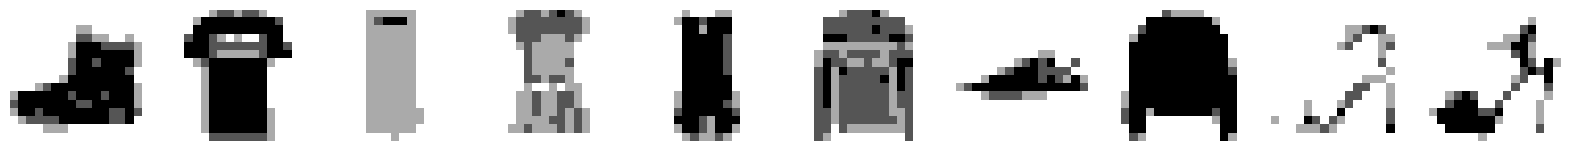

In [15]:
# Show some items of clothing from the training set
display(input_data)

The code in the following cell defines a custom layer called `MaskedConv2D` which extends the functionality of the standard 2D convolutional layer (`layers.Conv2D`) by including masking.



1. The `MaskedConv2D` class is defined as a subclass of `layers.Layer`, indicating that it is a custom layer.

2. The `__init__` method is the constructor of the class. It takes a `mask_type` parameter and any additional keyword arguments (`**kwargs`). It calls the constructor of the parent class (`super(MaskedConv2D, self).__init__()`) and initializes the `mask_type` attribute. It also creates an instance of `layers.Conv2D` with the provided `**kwargs` and assigns it to the `conv` attribute.

3. The `build` method is called when the layer is being built. It first builds the `conv` layer to initialize its kernel variables. Then, it retrieves the shape of the kernel using `self.conv.kernel.get_shape()` and creates a mask tensor (`self.mask`) with the same shape, initialized with zeros.

4. Depending on the `mask_type`, the mask is populated with ones in specific regions:
   - For the upper half of the kernel (excluding the center row), the mask values are set to 1.0.
   - For the left half of the center row (including the center pixel), the mask values are set to 1.0.
   - If the `mask_type` is "B", the center pixel of the kernel is also set to 1.0.

5. The `call` method is invoked when the layer is called with an input tensor. It multiplies the `conv` layer's kernel with the mask using element-wise multiplication (`self.conv.kernel * self.mask`). This effectively applies the mask to the kernel, zeroing out the desired regions. Then, it calls the `conv` layer with the masked kernel and returns the output.

6. The `get_config` method is used to retrieve the configuration of the layer. In this case, it simply calls the `get_config` method of the parent class and returns the configuration.

The purpose of this `MaskedConv2D` layer is to apply a mask to the convolutional kernel, allowing only certain regions of the kernel to be active during the convolution operation. This is particularly useful in architectures like PixelCNN, where the masking ensures that each pixel in the output depends only on the pixels above and to the left of it in the input, following a specific order.

In [20]:
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.shape # Changed to .shape
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

    def get_config(self):
        cfg = super().get_config()
        return cfg

The code in the following cell defines a custom layer called `ResidualBlock` which implements a residual block architecture commonly used in deep neural networks. Residual blocks allow the network to learn residual functions and facilitate the training of deep networks by alleviating the vanishing gradient problem.


1. The `ResidualBlock` class is defined as a subclass of `layers.Layer`, indicating that it is a custom layer.

2. The `__init__` method is the constructor of the class. It takes a `filters` parameter, which determines the number of filters in the convolutional layers, and any additional keyword arguments (`**kwargs`). It calls the constructor of the parent class (`super(ResidualBlock, self).__init__(**kwargs)`).

3. Inside the constructor, three convolutional layers are defined:
   - `self.conv1`: A standard 2D convolutional layer (`layers.Conv2D`) with `filters // 2` filters (half the input filters), kernel size of 1, and ReLU activation.
   - `self.pixel_conv`: An instance of the `MaskedConv2D` layer (defined in the previous code snippet) with mask type "B", `filters // 2` filters (half the input filters), kernel size of 3, ReLU activation, and "same" padding.
   - `self.conv2`: Another standard 2D convolutional layer with `filters` filters (same as the input filters), kernel size of 1, and ReLU activation.

4. The `call` method is invoked when the layer is called with an input tensor. It defines the forward pass of the residual block:
   - The input tensor is passed through `self.conv1`, followed by `self.pixel_conv`, and then `self.conv2`.
   - The output of `self.conv2` is added element-wise to the original input tensor using `layers.add([inputs, x])`, creating the residual connection.
   - The result of the element-wise addition is returned as the output of the residual block.

5. The `get_config` method is used to retrieve the configuration of the layer. In this case, it simply calls the `get_config` method of the parent class and returns the configuration.

The purpose of this `ResidualBlock` is to learn residual functions by allowing the network to pass information from the input directly to the output through the residual connection. The block consists of two branches:
- The main branch applies a series of convolutional operations (conv1 → pixel_conv → conv2) to the input.
- The residual branch simply passes the input directly to the output.

The outputs of both branches are then added element-wise, enabling the network to learn the residual function. This residual connection helps in training deep networks by allowing the gradients to flow more easily through the network, mitigating the vanishing gradient problem.

The `MaskedConv2D` layer used in the `pixel_conv` ensures that the convolution operation follows a specific masking pattern, which is useful in a PixelCNN.

In [21]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters // 2, kernel_size=1, activation="relu"
        )
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])

    def get_config(self):
        cfg = super().get_config()
        return cfg

The code below defines the architecture of a PixelCNN model using the Keras functional API.

1. `inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))`:
   - This line defines the input layer of the model using `layers.Input`.
   - The input shape is specified as `(IMAGE_SIZE, IMAGE_SIZE, 1)`, indicating that the input images have a height and width of `IMAGE_SIZE` and a single channel (grayscale).

2. `x = MaskedConv2D(mask_type="A", filters=N_FILTERS, kernel_size=7, activation="relu", padding="same")(inputs)`:
   - The input tensor is passed through a `MaskedConv2D` layer with mask type "A", `N_FILTERS` filters, a kernel size of 7, ReLU activation, and "same" padding.
   - This layer applies a masked convolution operation to the input, allowing the model to capture local dependencies.

3. `for _ in range(RESIDUAL_BLOCKS): x = ResidualBlock(filters=N_FILTERS)(x)`:
   - This loop creates a stack of `RESIDUAL_BLOCKS` residual blocks.
   - Each residual block is created using the `ResidualBlock` layer defined in the previous code snippet, with `N_FILTERS` filters.
   - The output of each residual block is assigned back to `x`, forming a deep residual network.

4. `for _ in range(2): x = MaskedConv2D(mask_type="B", filters=N_FILTERS, kernel_size=1, strides=1, activation="relu", padding="valid")(x)`:
   - This loop applies two additional `MaskedConv2D` layers with mask type "B", `N_FILTERS` filters, a kernel size of 1, stride of 1, ReLU activation, and "valid" padding.
   - These layers further process the output of the residual blocks.

5. `out = layers.Conv2D(filters=PIXEL_LEVELS, kernel_size=1, strides=1, activation="softmax", padding="valid")(x)`:
   - The final layer is a standard 2D convolutional layer (`layers.Conv2D`) with `PIXEL_LEVELS` filters, a kernel size of 1, stride of 1, softmax activation, and "valid" padding.
   - This layer produces the output of the model, representing the probability distribution over the pixel values.

6. `pixel_cnn = models.Model(inputs, out)`:
   - The `pixel_cnn` model is created using `models.Model`, specifying the input tensor (`inputs`) and the output tensor (`out`).
   - This defines the complete PixelCNN model architecture.

7. `pixel_cnn.summary()`:
   - This line prints a summary of the PixelCNN model architecture, displaying the layers, their output shapes, and the number of parameters in each layer.

The resulting `pixel_cnn` model is a deep convolutional neural network that learns to generate images pixel by pixel. The architecture consists of a stack of masked convolutional layers and residual blocks, which capture the dependencies between pixels and allow the model to generate coherent and realistic images.

The use of masked convolutions ensures that the model follows a specific order in generating pixels, where each pixel depends only on the pixels above and to the left of it in the image.

In [22]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS,
    kernel_size=7,
    activation="relu",
    padding="same",
)(inputs)

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)

for _ in range(2):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = layers.Conv2D(
    filters=PIXEL_LEVELS,
    kernel_size=1,
    strides=1,
    activation="softmax",
    padding="valid",
)(x)

pixel_cnn = models.Model(inputs, out)
pixel_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 16, 16, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masked_conv2d_3 (MaskedConv2D)       │ (None, 16, 16, 128)         │           6,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ (None, 16, 16, 128)         │          53,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_1 (ResidualBlock)     │ (None, 16, 16, 128)         │          53,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_2 (ResidualBlock)     │ (None, 16, 16, 128)         │          53,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_3 (ResidualBlock)     │ (None, 16, 16, 128)         │          53,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_4 (ResidualBlock)     │ (None, 16, 16, 128)         │          53,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masked_conv2d_9 (MaskedConv2D)       │ (None, 16, 16, 128)         │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masked_conv2d_10 (MaskedConv2D)      │ (None, 16, 16, 128)         │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 16, 16, 4)           │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 307,460 (1.17 MB)

 Trainable params: 307,460 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
adam = optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [24]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixel_cnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :
                    ]
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ]
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature=1.0)
        display(
            generated_images,
            save_to="/content/images/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=10)

In [25]:
!mkdir ./images

Epoch 1/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6501
Saved to /content/images/generated_img_000.png


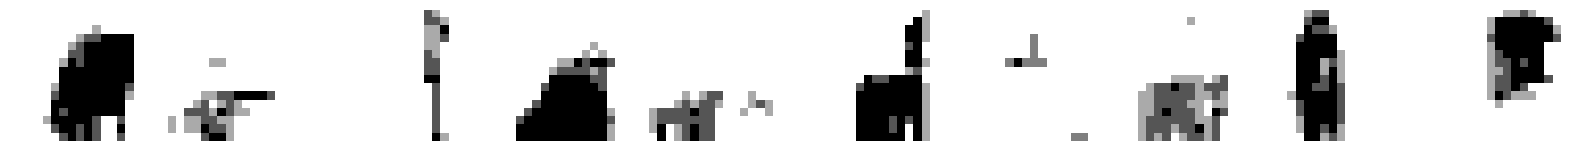

469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 56ms/step - loss: 0.6497
Epoch 2/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4052
Saved to /content/images/generated_img_001.png


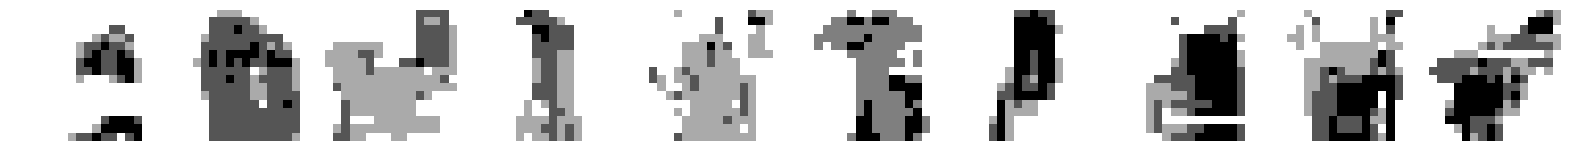

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 0.4051
Epoch 3/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3903
Saved to /content/images/generated_img_002.png


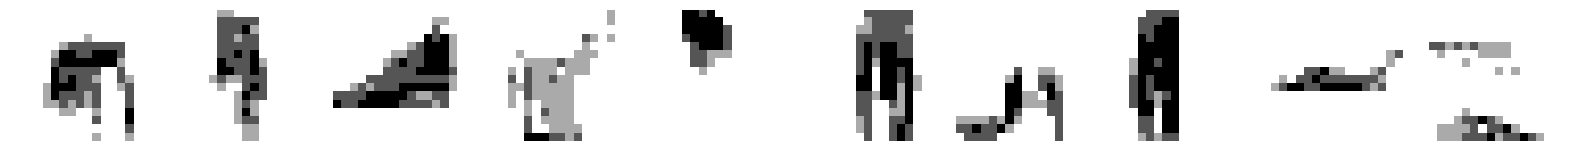

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 0.3903
Epoch 4/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3838
Saved to /content/images/generated_img_003.png


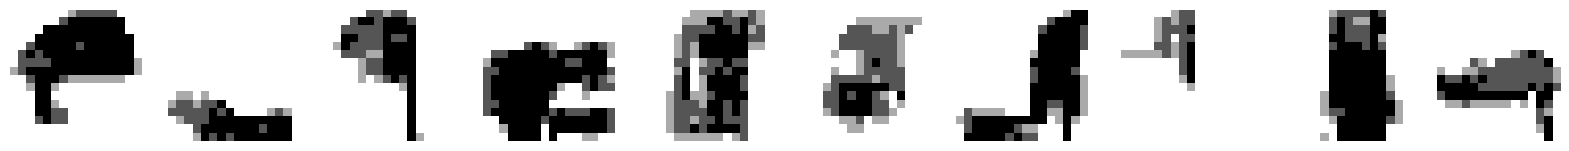

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3838
Epoch 5/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3778
Saved to /content/images/generated_img_004.png


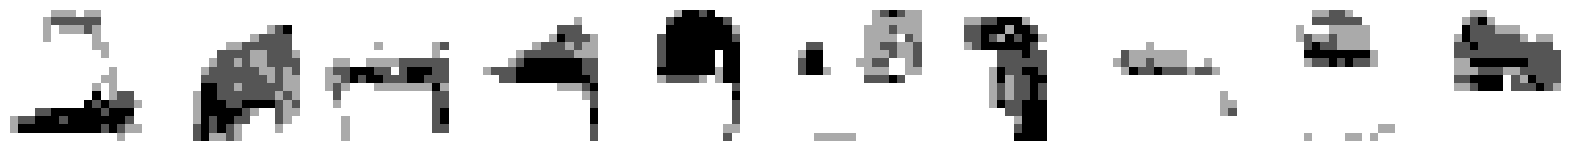

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3778
Epoch 6/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3743
Saved to /content/images/generated_img_005.png


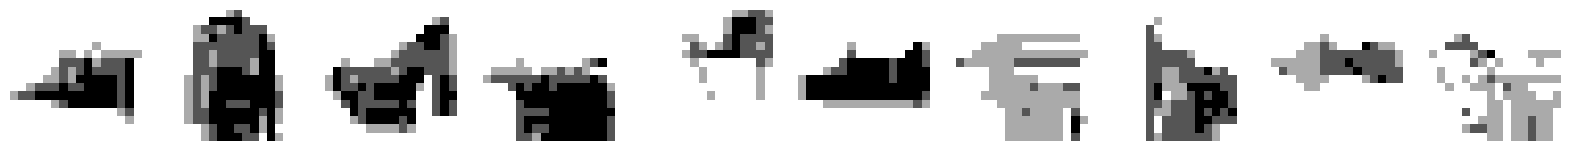

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3743
Epoch 7/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3709
Saved to /content/images/generated_img_006.png


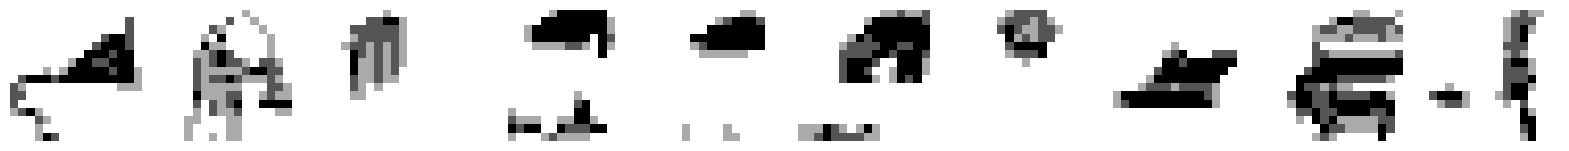

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3709
Epoch 8/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3690
Saved to /content/images/generated_img_007.png


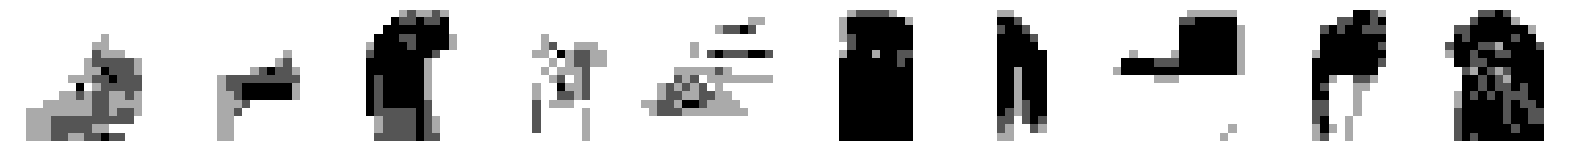

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3690
Epoch 9/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3660
Saved to /content/images/generated_img_008.png


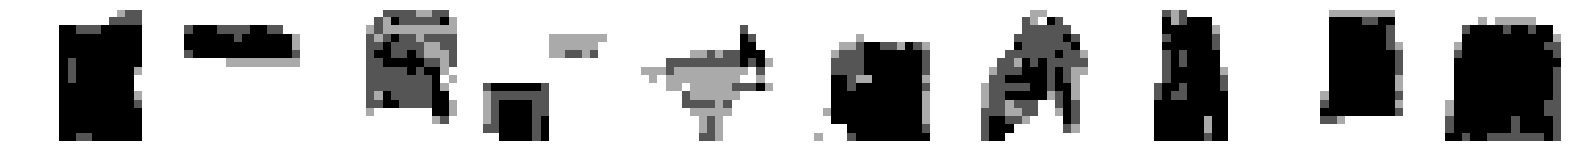

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3660
Epoch 10/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3650
Saved to /content/images/generated_img_009.png


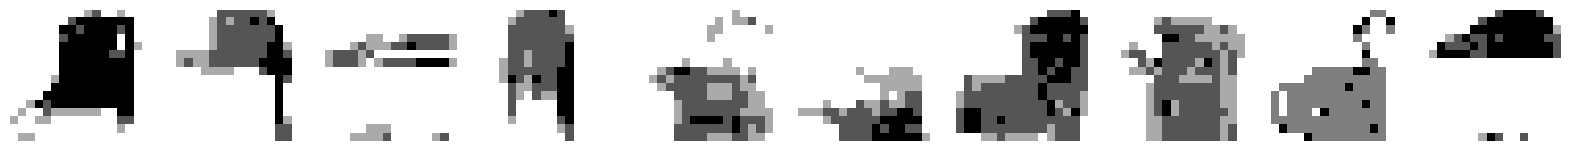

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3650
Epoch 11/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3614
Saved to /content/images/generated_img_010.png


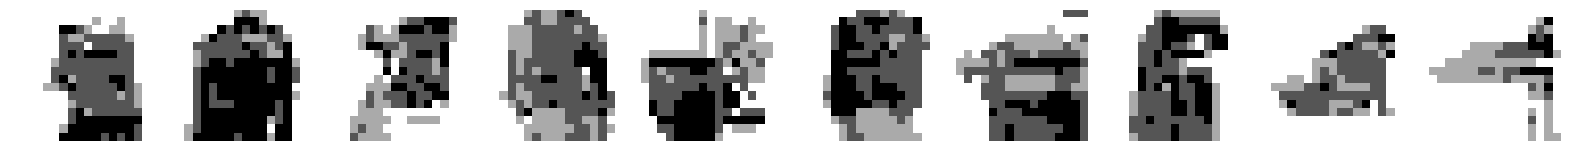

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3614
Epoch 12/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3595
Saved to /content/images/generated_img_011.png


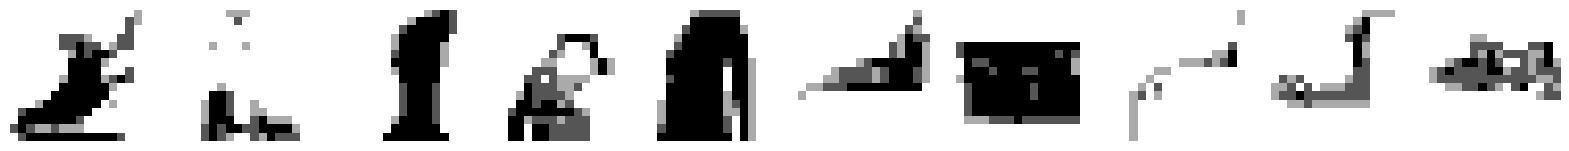

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3595
Epoch 13/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3578
Saved to /content/images/generated_img_012.png


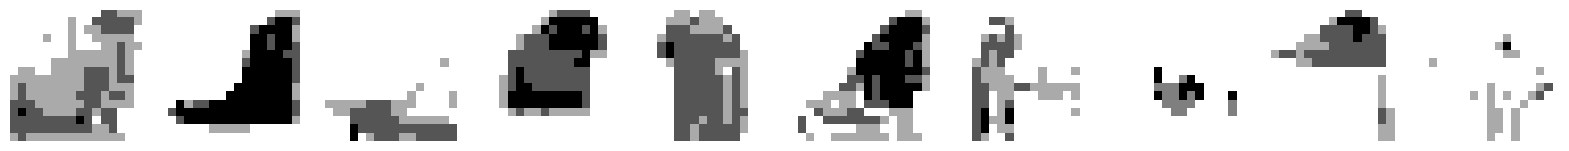

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.3578
Epoch 14/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3560
Saved to /content/images/generated_img_013.png


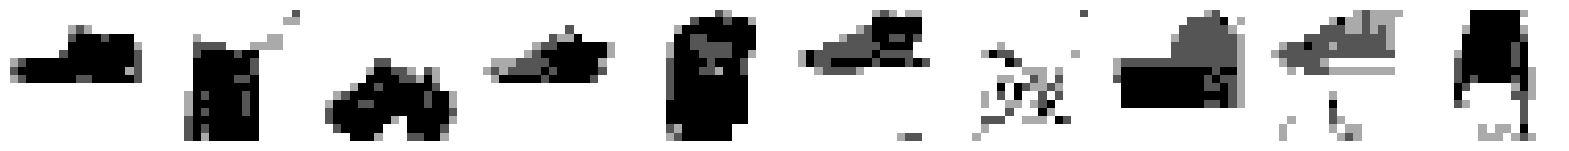

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3560
Epoch 15/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3557
Saved to /content/images/generated_img_014.png


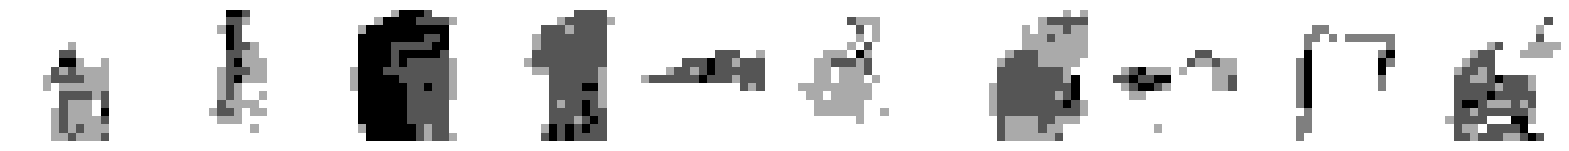

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3557
Epoch 16/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3536
Saved to /content/images/generated_img_015.png


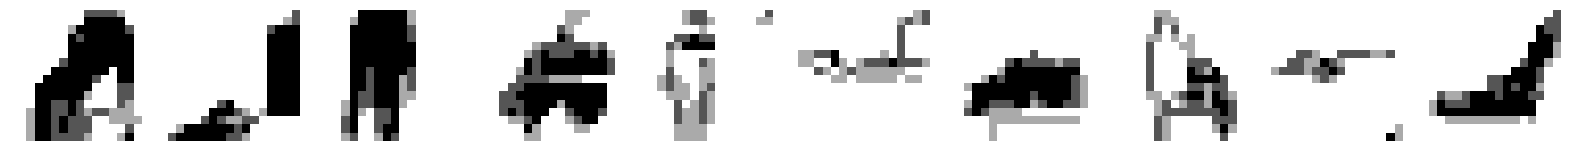

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3536
Epoch 17/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3521
Saved to /content/images/generated_img_016.png


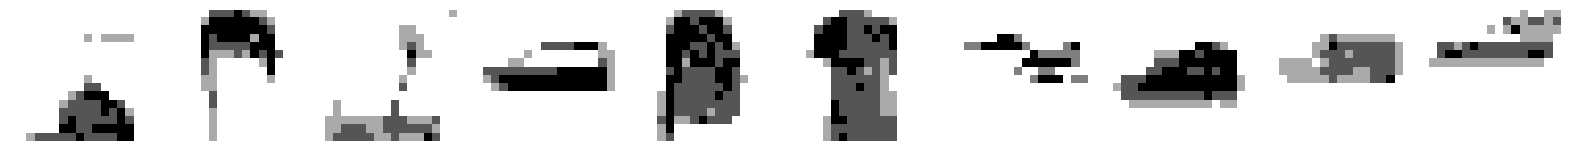

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3521
Epoch 18/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3524
Saved to /content/images/generated_img_017.png


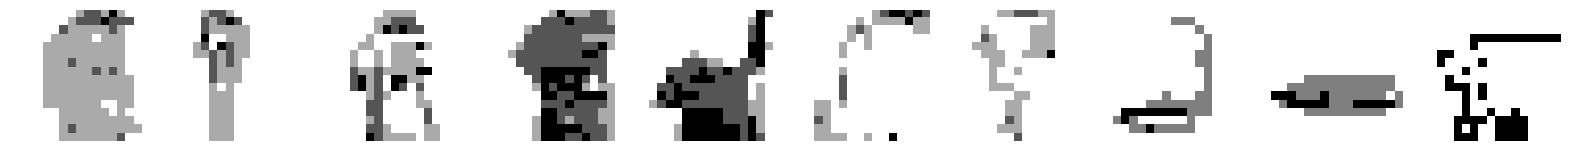

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.3524
Epoch 19/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3514
Saved to /content/images/generated_img_018.png


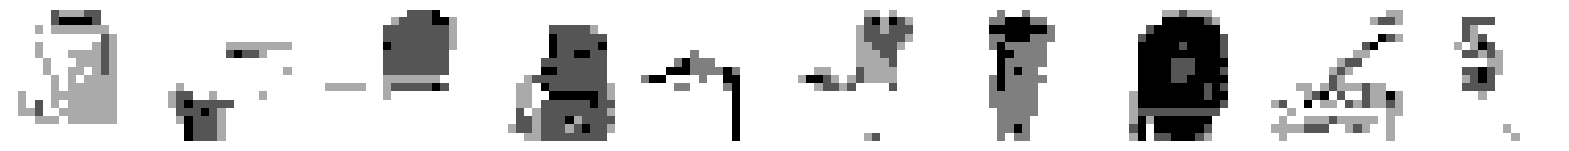

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3513
Epoch 20/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3493
Saved to /content/images/generated_img_019.png


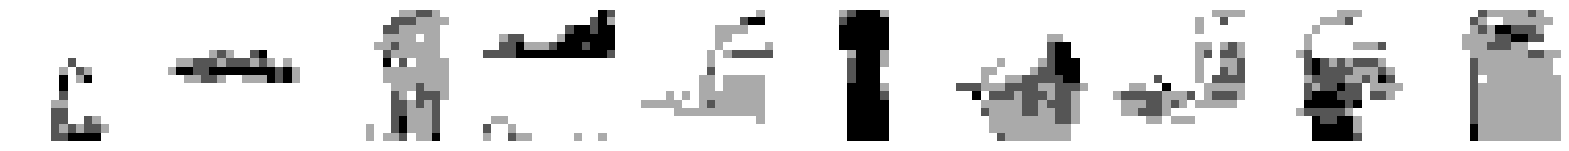

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3493
Epoch 21/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3481
Saved to /content/images/generated_img_020.png


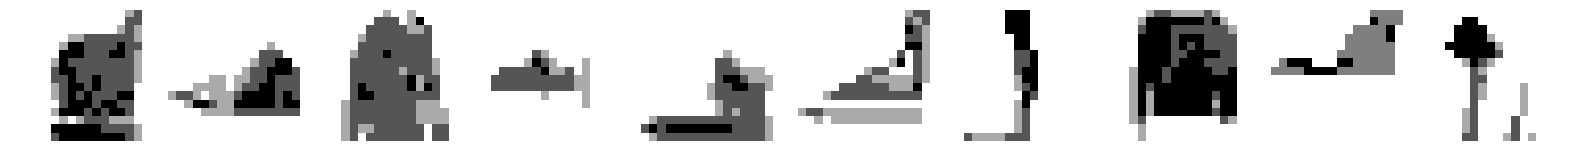

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3481
Epoch 22/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3478
Saved to /content/images/generated_img_021.png


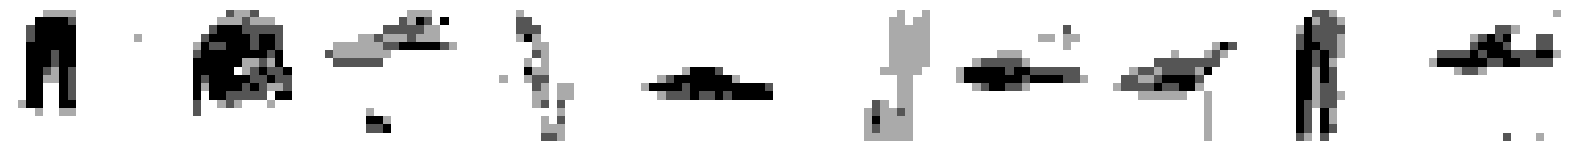

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3478
Epoch 23/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3475
Saved to /content/images/generated_img_022.png


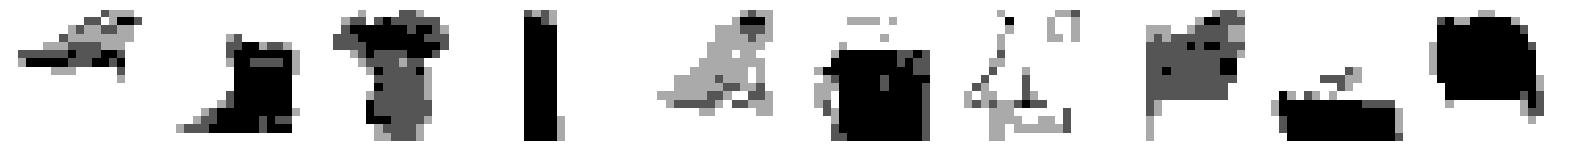

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.3475
Epoch 24/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3455
Saved to /content/images/generated_img_023.png


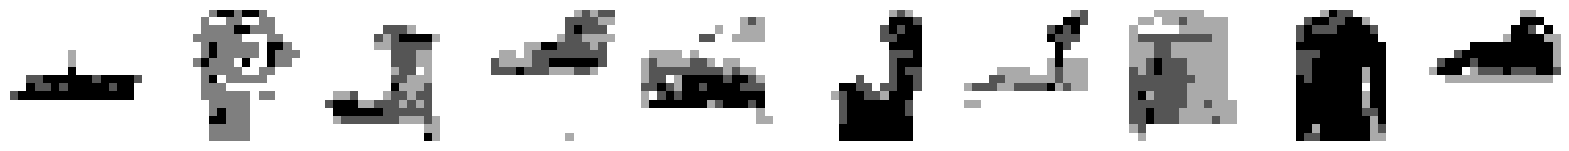

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.3455
Epoch 25/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3451
Saved to /content/images/generated_img_024.png


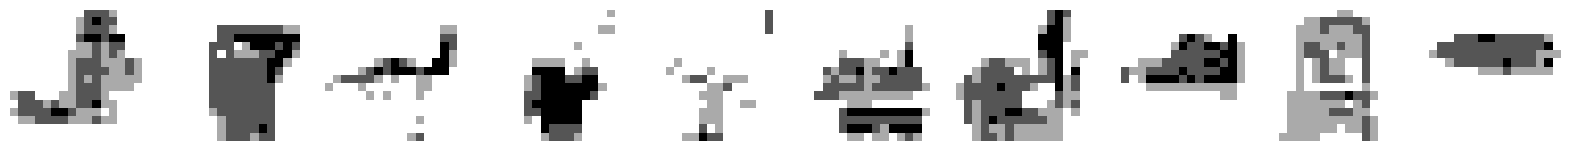

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3451
Epoch 26/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3444
Saved to /content/images/generated_img_025.png


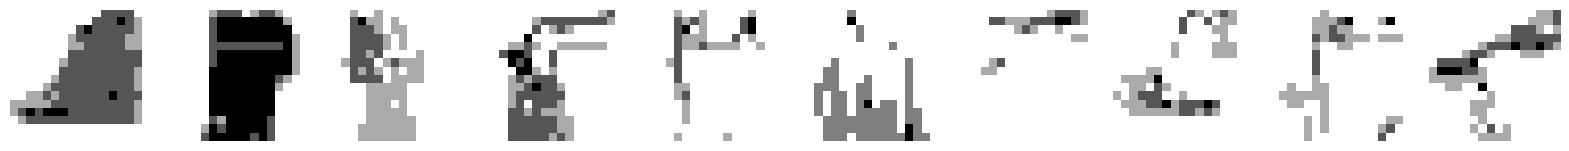

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3444
Epoch 27/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3446
Saved to /content/images/generated_img_026.png


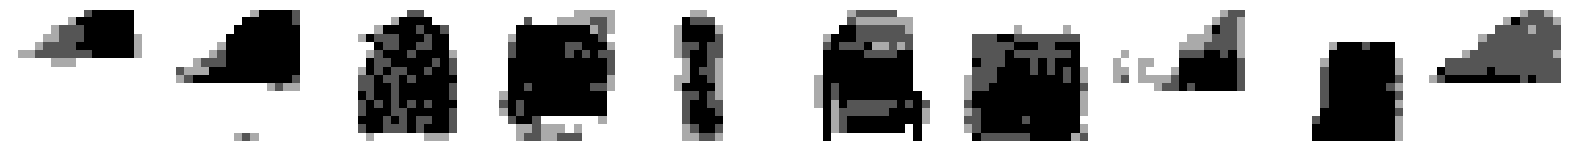

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.3446
Epoch 28/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3445
Saved to /content/images/generated_img_027.png


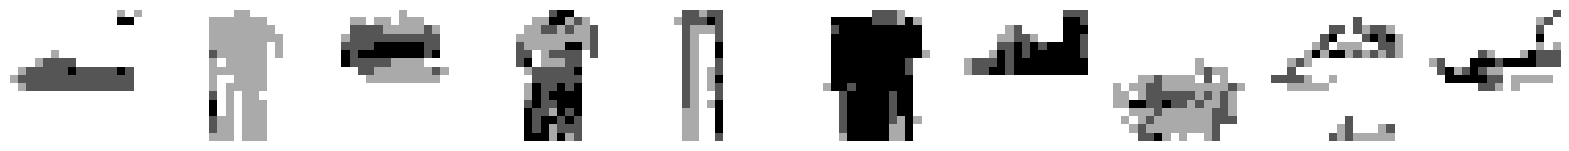

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.3445
Epoch 29/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3434
Saved to /content/images/generated_img_028.png


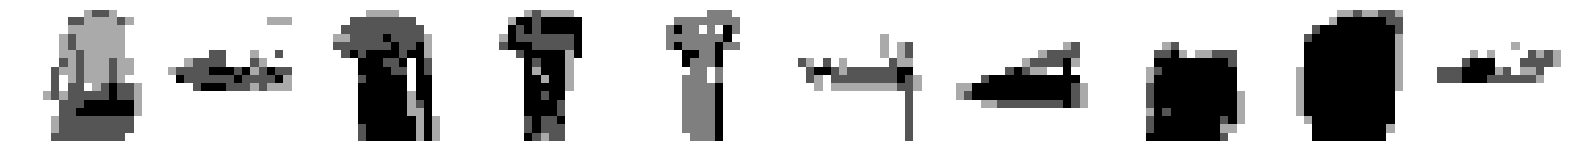

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3434
Epoch 30/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3430
Saved to /content/images/generated_img_029.png


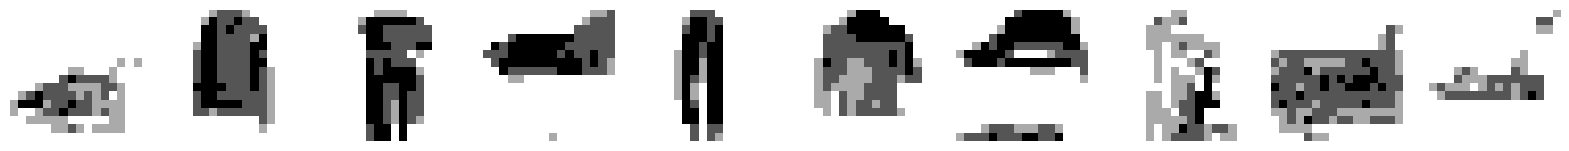

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3430
Epoch 31/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3421
Saved to /content/images/generated_img_030.png


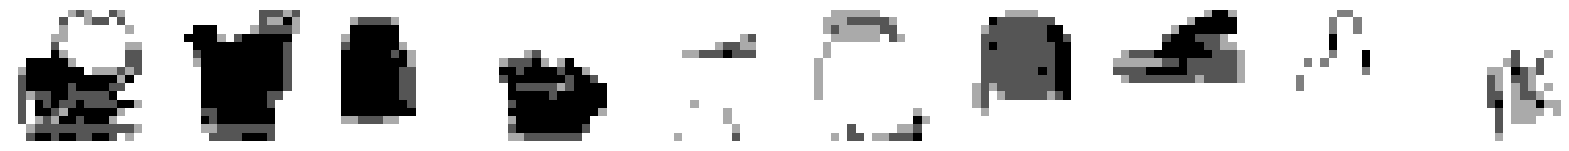

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3421
Epoch 32/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3421
Saved to /content/images/generated_img_031.png


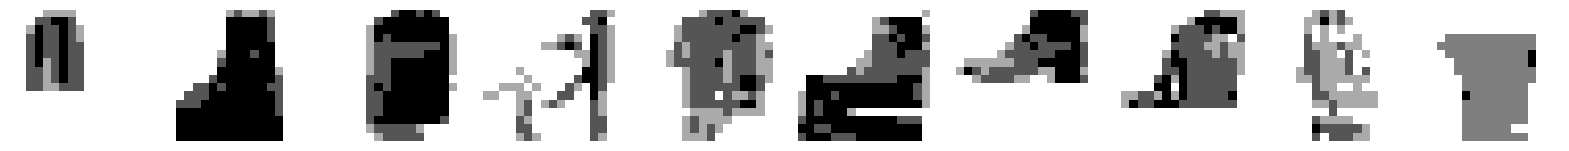

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.3421
Epoch 33/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3414
Saved to /content/images/generated_img_032.png


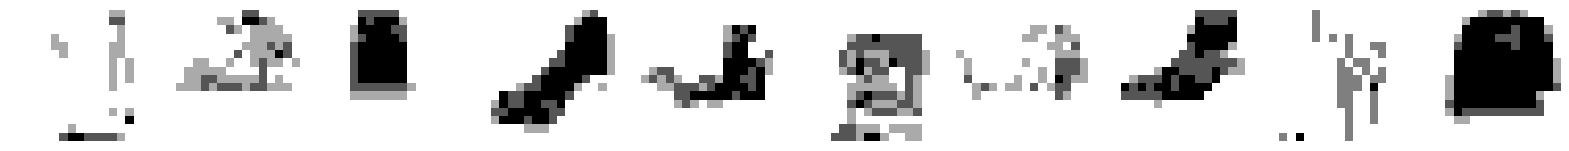

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.3414
Epoch 34/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3405
Saved to /content/images/generated_img_033.png


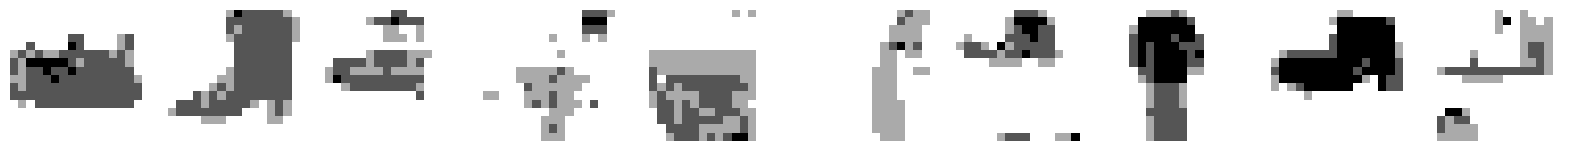

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3405
Epoch 35/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3415
Saved to /content/images/generated_img_034.png


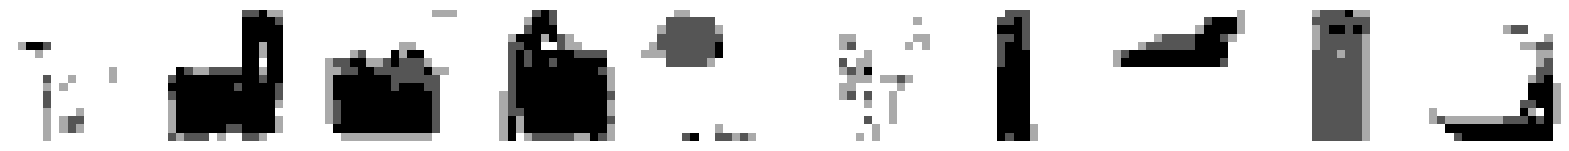

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3414
Epoch 36/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3393
Saved to /content/images/generated_img_035.png


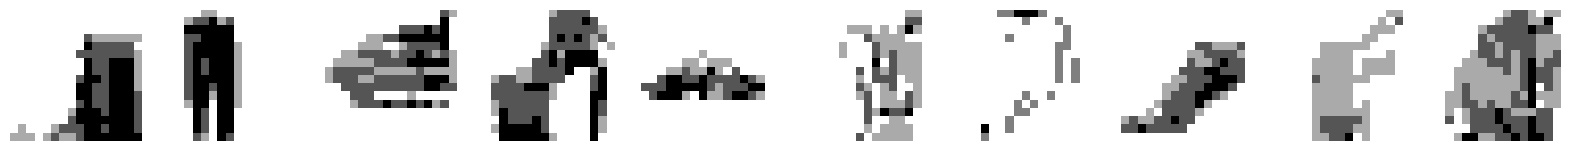

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3393
Epoch 37/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3387
Saved to /content/images/generated_img_036.png


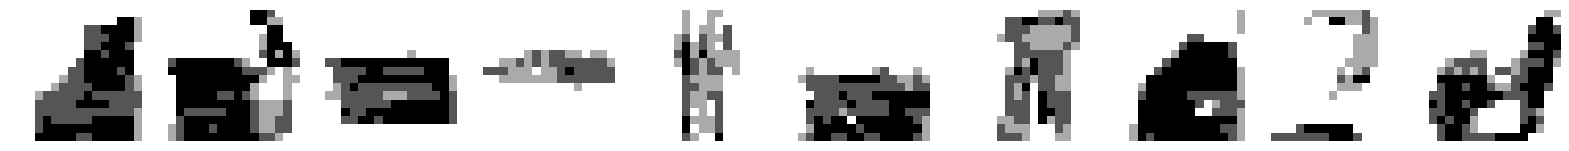

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.3387
Epoch 38/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3396
Saved to /content/images/generated_img_037.png


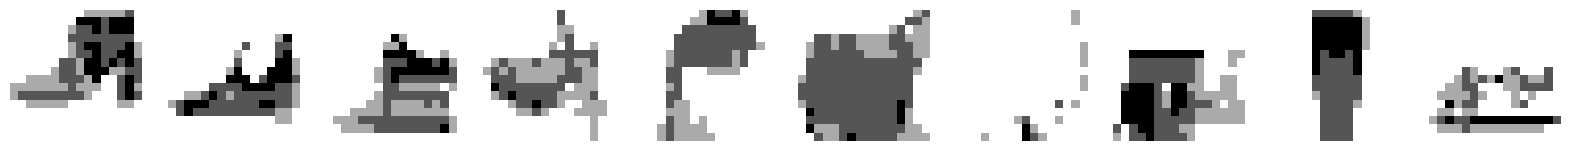

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3396
Epoch 39/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3387
Saved to /content/images/generated_img_038.png


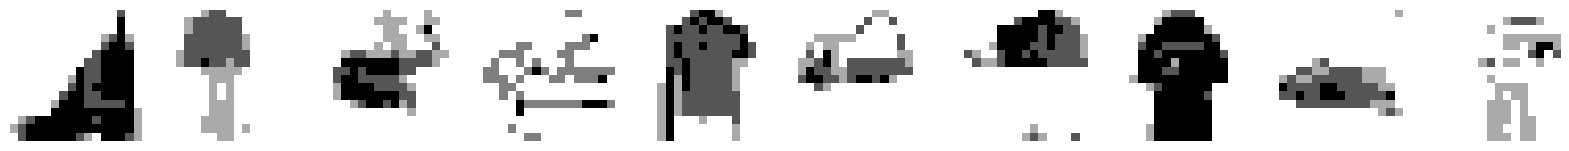

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3387
Epoch 40/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3385
Saved to /content/images/generated_img_039.png


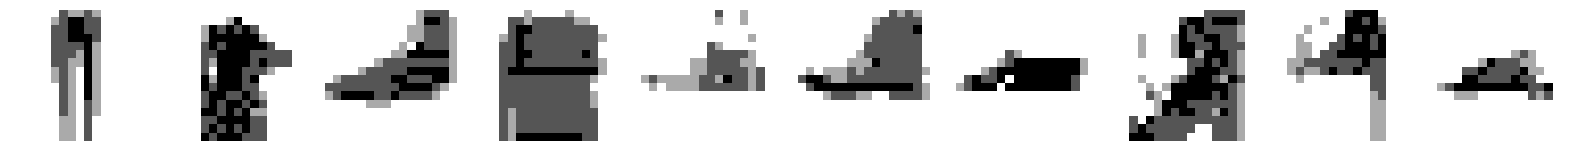

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3385
Epoch 41/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3367
Saved to /content/images/generated_img_040.png


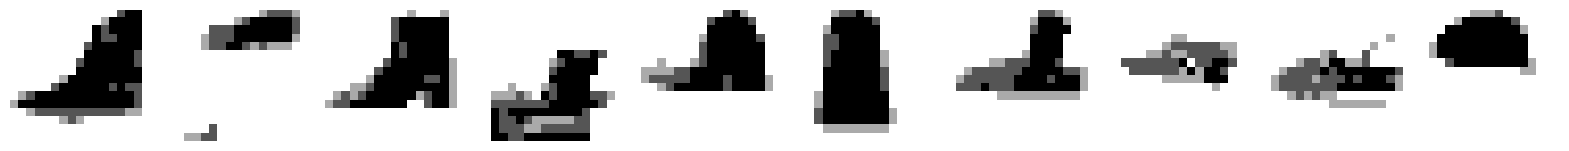

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.3367
Epoch 42/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3381
Saved to /content/images/generated_img_041.png


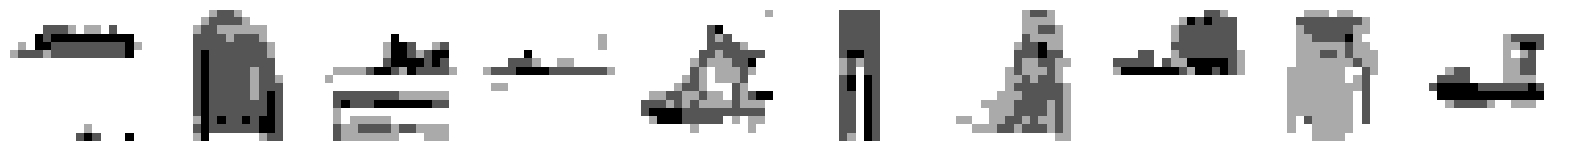

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3381
Epoch 43/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3374
Saved to /content/images/generated_img_042.png


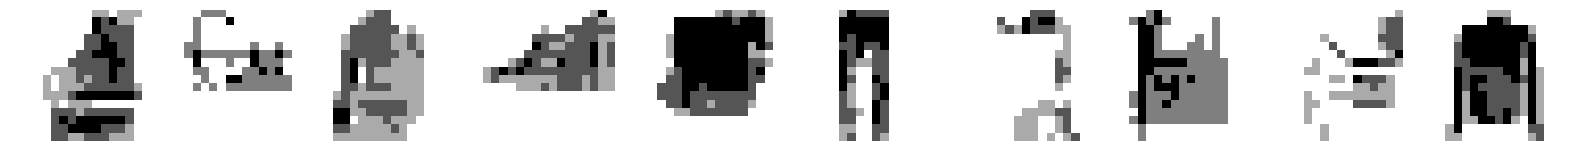

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3374
Epoch 44/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3361
Saved to /content/images/generated_img_043.png


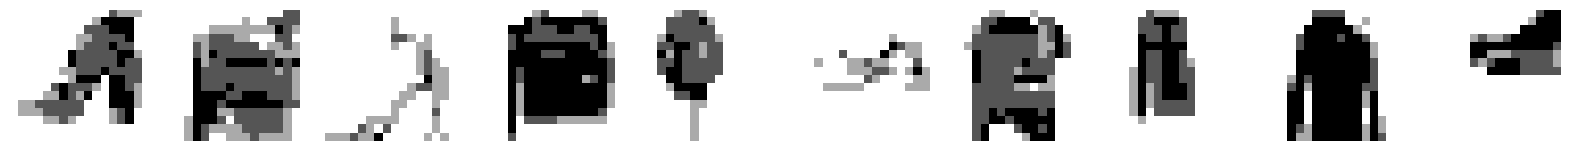

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3361
Epoch 45/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3371
Saved to /content/images/generated_img_044.png


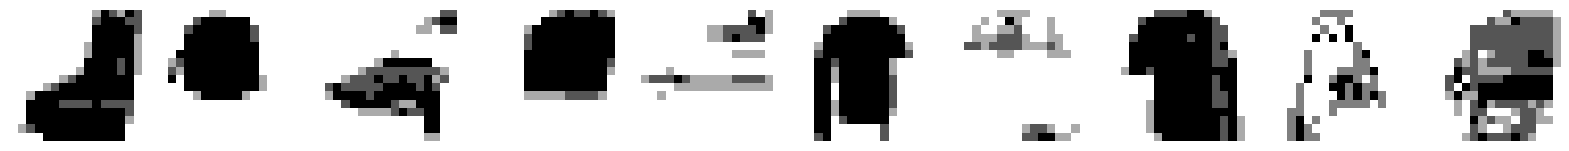

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3371
Epoch 46/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3363
Saved to /content/images/generated_img_045.png


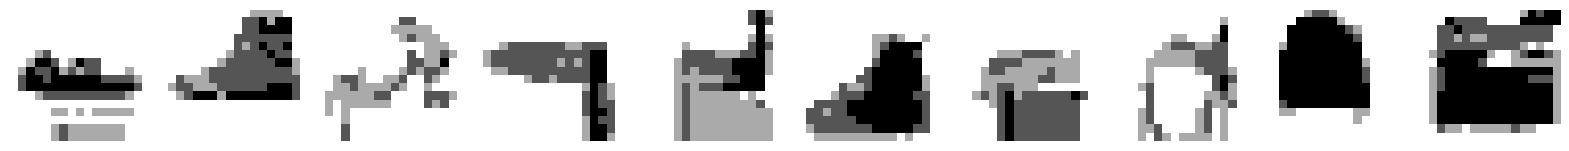

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.3363
Epoch 47/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3355
Saved to /content/images/generated_img_046.png


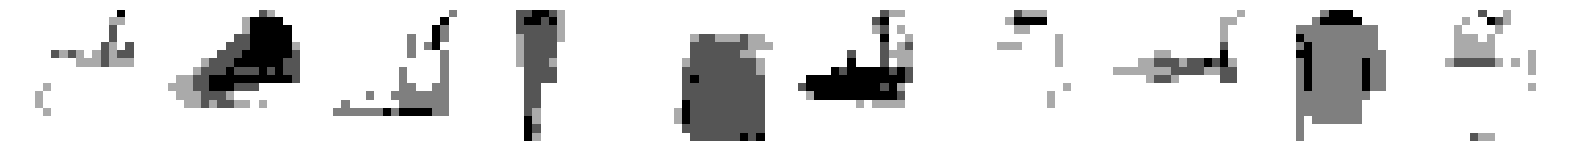

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.3355
Epoch 48/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3370
Saved to /content/images/generated_img_047.png


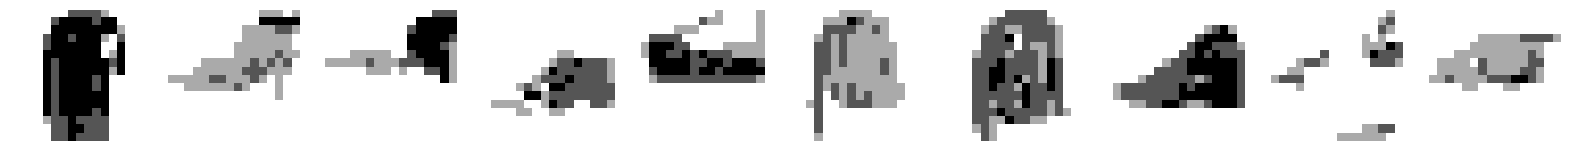

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3370
Epoch 49/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3353
Saved to /content/images/generated_img_048.png


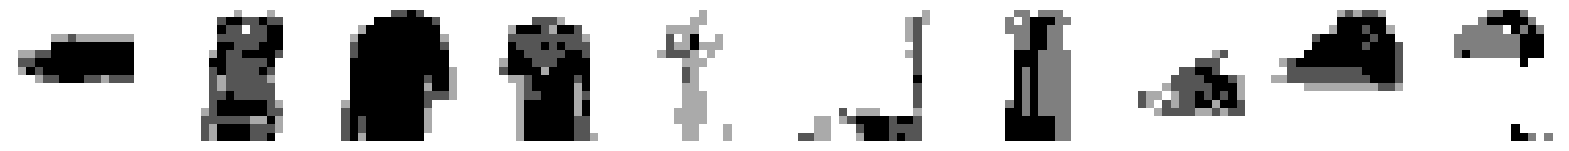

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 0.3353
Epoch 50/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3342
Saved to /content/images/generated_img_049.png


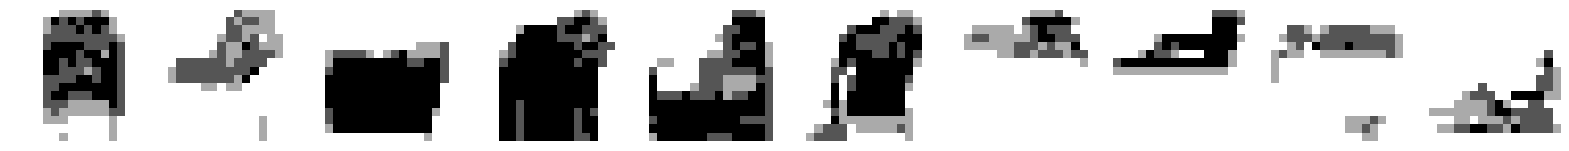

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.3342
Epoch 51/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3341
Saved to /content/images/generated_img_050.png


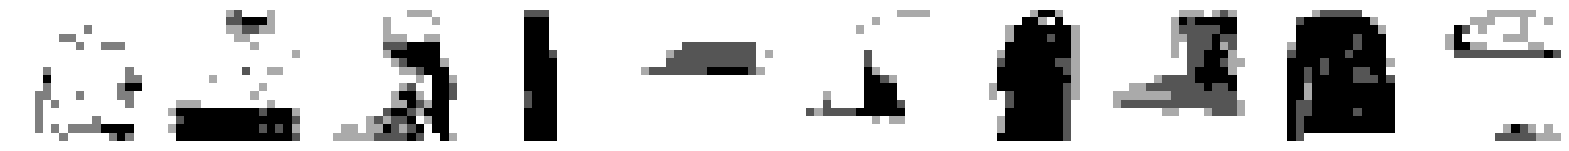

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.3341
Epoch 52/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3346
Saved to /content/images/generated_img_051.png


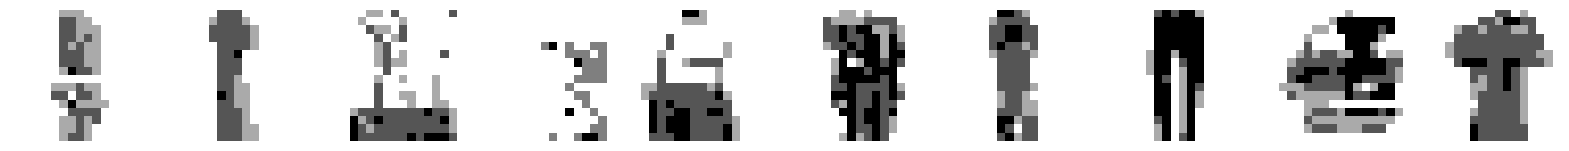

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3346
Epoch 53/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3350
Saved to /content/images/generated_img_052.png


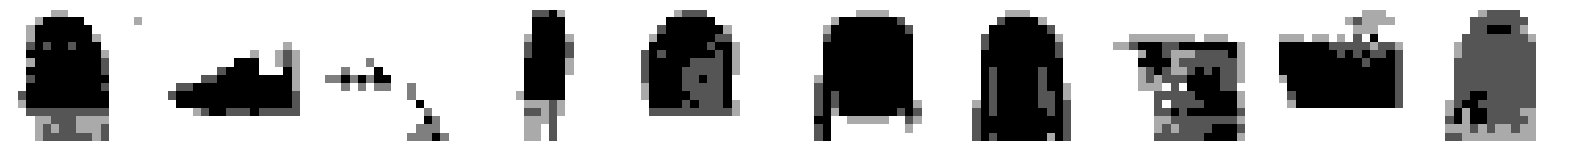

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3350
Epoch 54/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3347
Saved to /content/images/generated_img_053.png


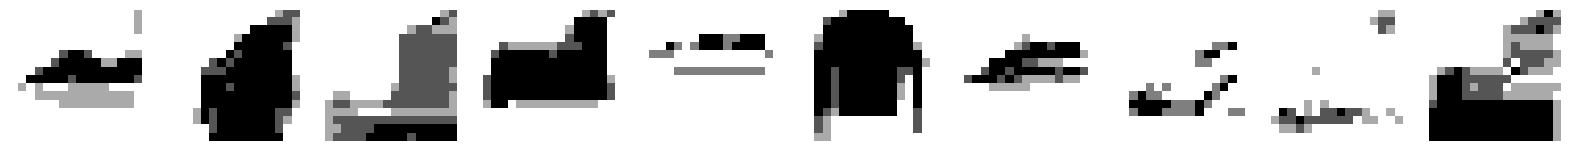

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3347
Epoch 55/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3350
Saved to /content/images/generated_img_054.png


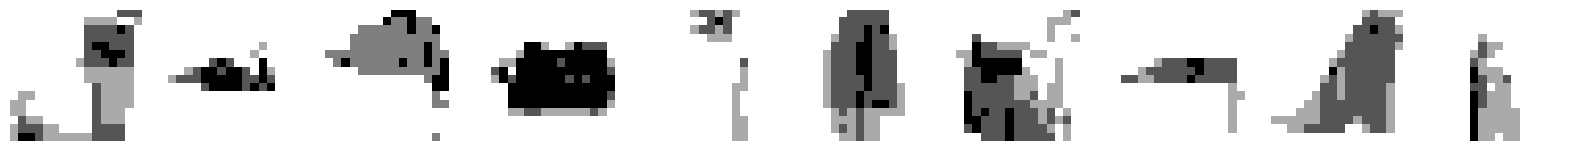

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.3350
Epoch 56/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3335
Saved to /content/images/generated_img_055.png


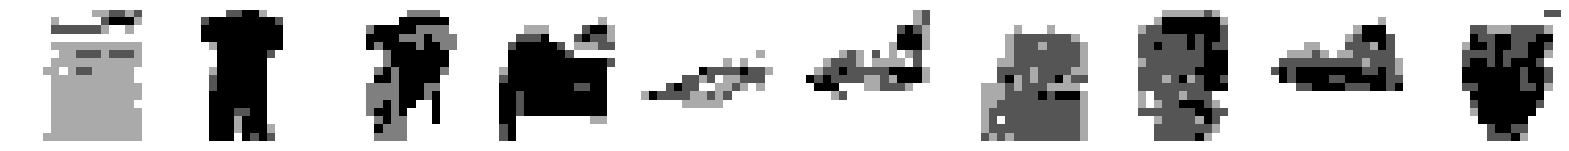

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.3335
Epoch 57/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3345
Saved to /content/images/generated_img_056.png


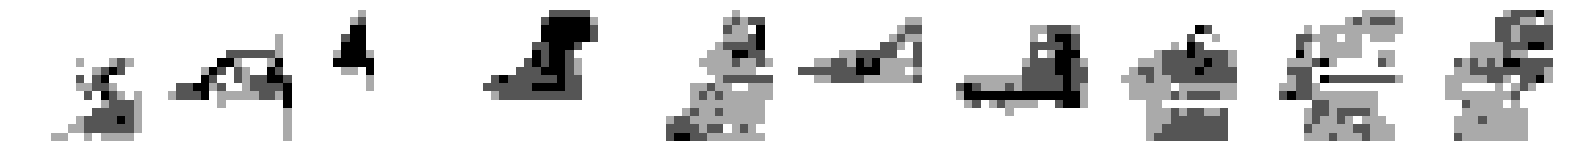

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3345
Epoch 58/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3328
Saved to /content/images/generated_img_057.png


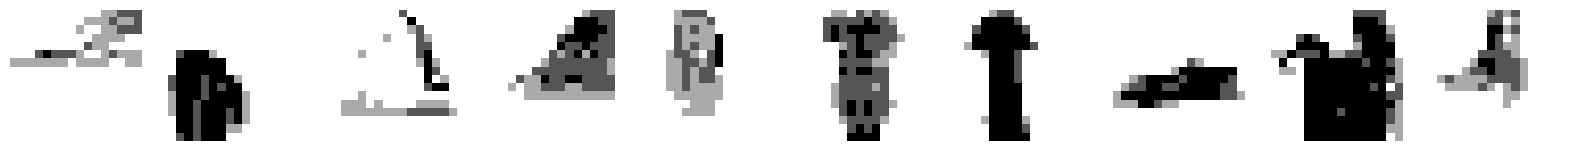

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3328
Epoch 59/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3329
Saved to /content/images/generated_img_058.png


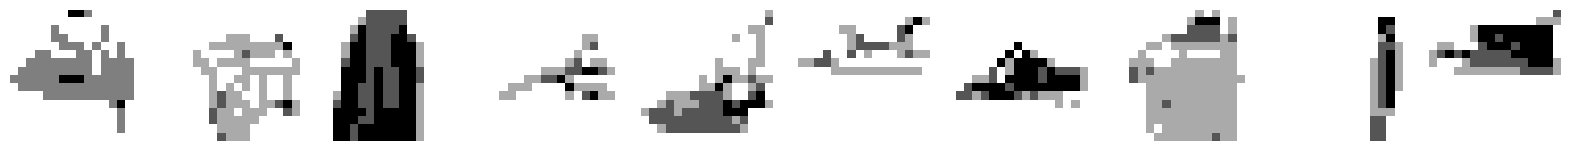

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3329
Epoch 60/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3333
Saved to /content/images/generated_img_059.png


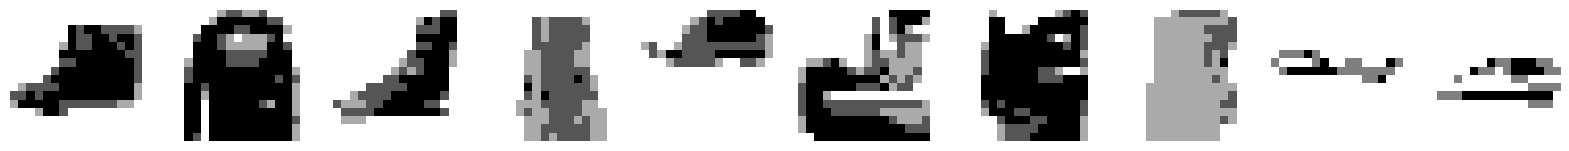

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - loss: 0.3333
Epoch 61/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3333
Saved to /content/images/generated_img_060.png


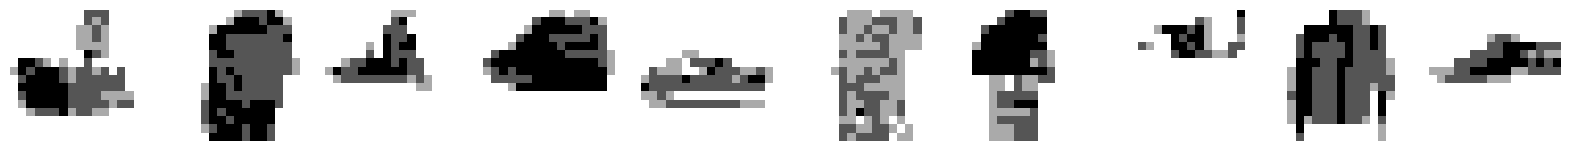

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - loss: 0.3333
Epoch 62/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3331
Saved to /content/images/generated_img_061.png


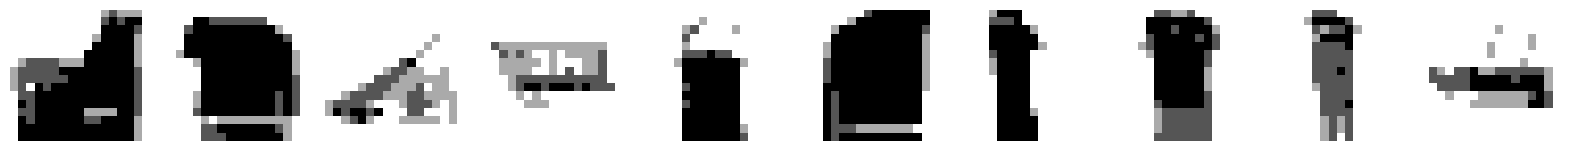

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3331
Epoch 63/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3327
Saved to /content/images/generated_img_062.png


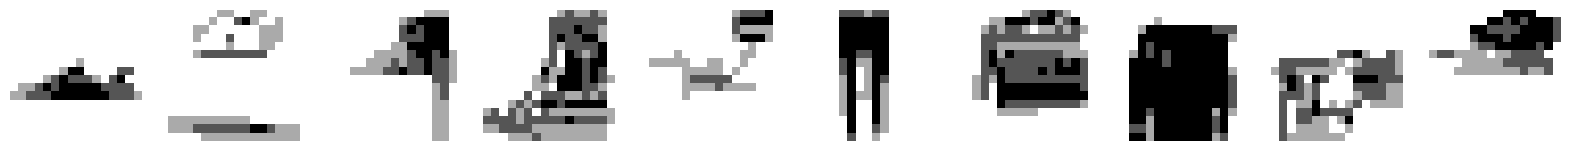

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3327
Epoch 64/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3319
Saved to /content/images/generated_img_063.png


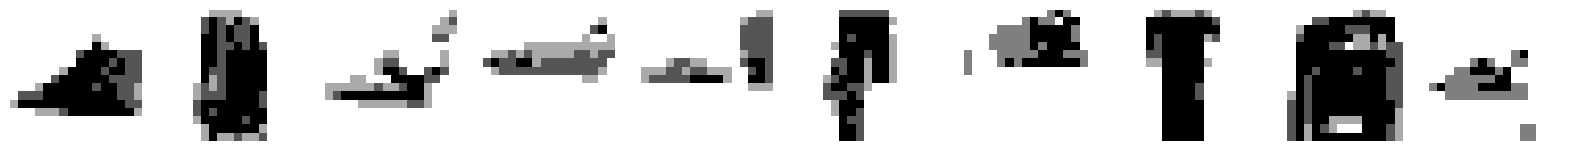

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - loss: 0.3319
Epoch 65/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3324
Saved to /content/images/generated_img_064.png


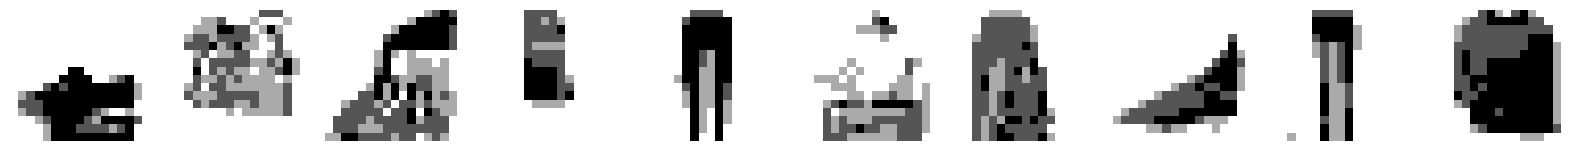

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.3324
Epoch 66/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3322
Saved to /content/images/generated_img_065.png


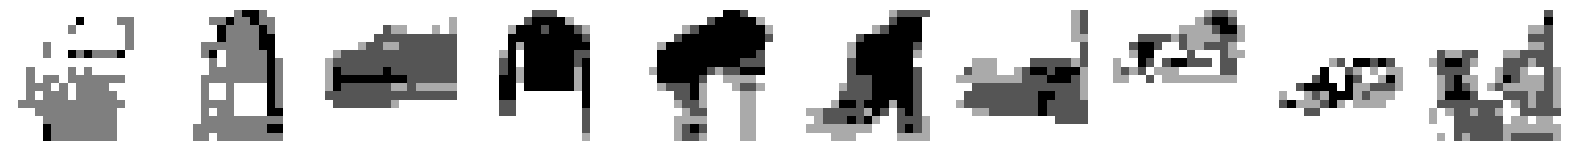

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.3322
Epoch 67/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3316
Saved to /content/images/generated_img_066.png


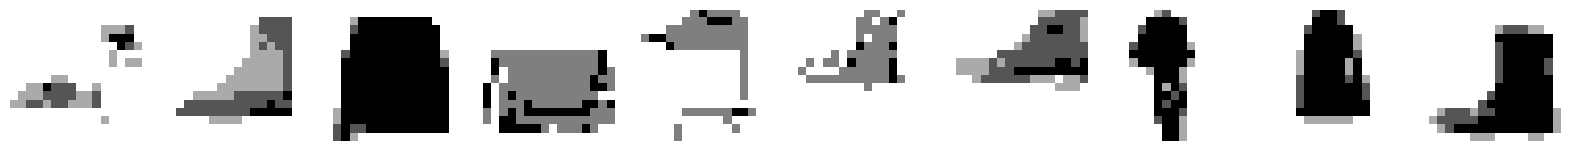

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3316
Epoch 68/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3321
Saved to /content/images/generated_img_067.png


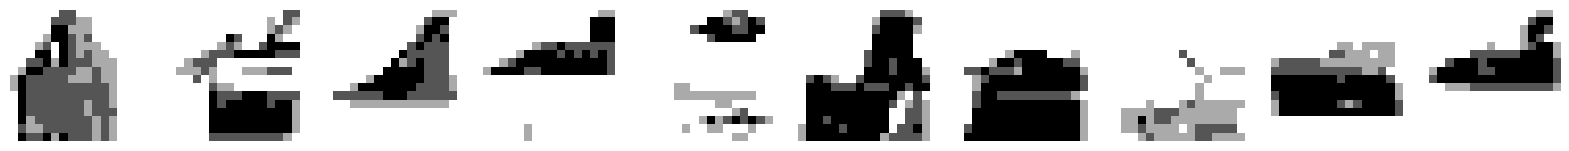

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3321
Epoch 69/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3311
Saved to /content/images/generated_img_068.png


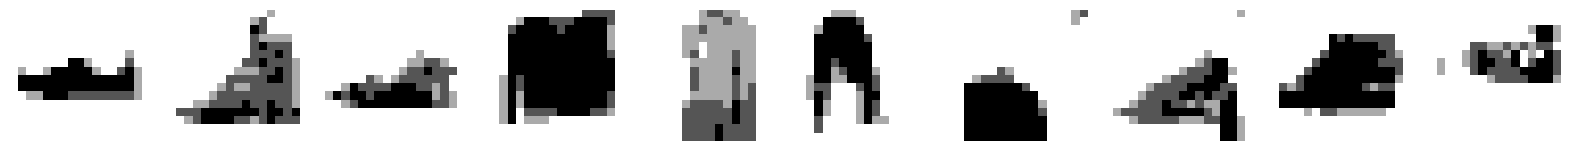

469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - loss: 0.3311
Epoch 70/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3314
Saved to /content/images/generated_img_069.png


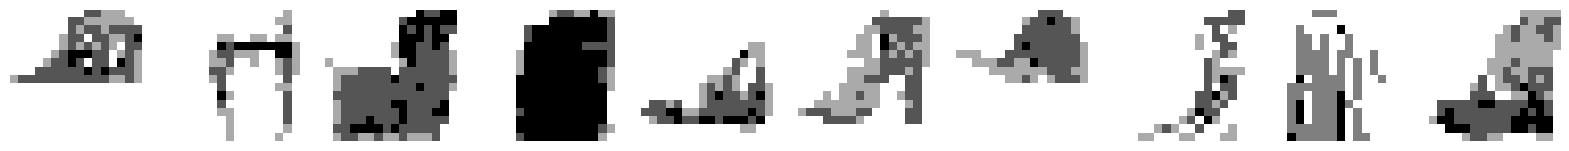

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - loss: 0.3314
Epoch 71/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3305
Saved to /content/images/generated_img_070.png


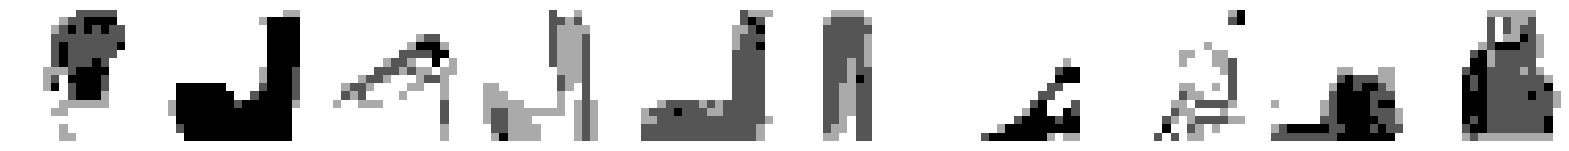

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.3306
Epoch 72/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3306
Saved to /content/images/generated_img_071.png


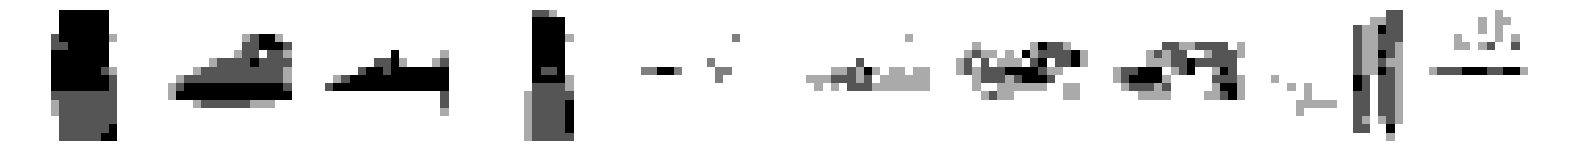

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3306
Epoch 73/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3314
Saved to /content/images/generated_img_072.png


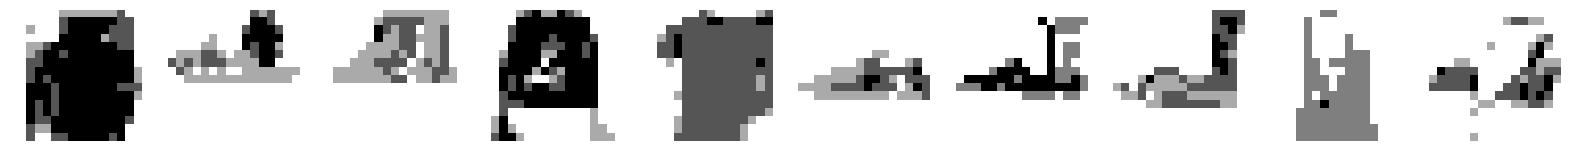

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3314
Epoch 74/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3304
Saved to /content/images/generated_img_073.png


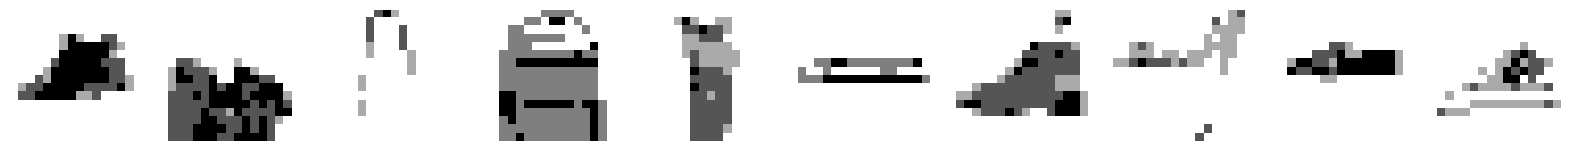

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - loss: 0.3304
Epoch 75/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3312
Saved to /content/images/generated_img_074.png


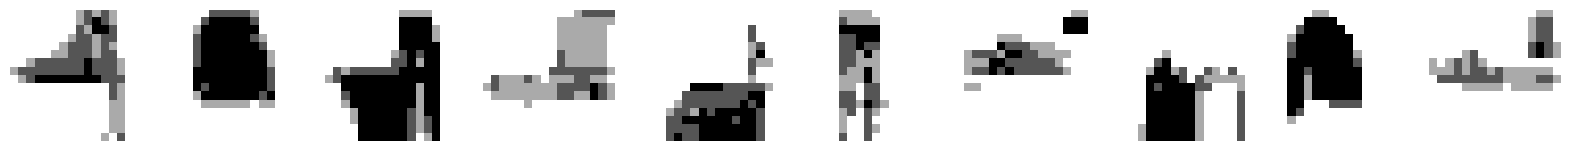

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.3312
Epoch 76/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3298
Saved to /content/images/generated_img_075.png


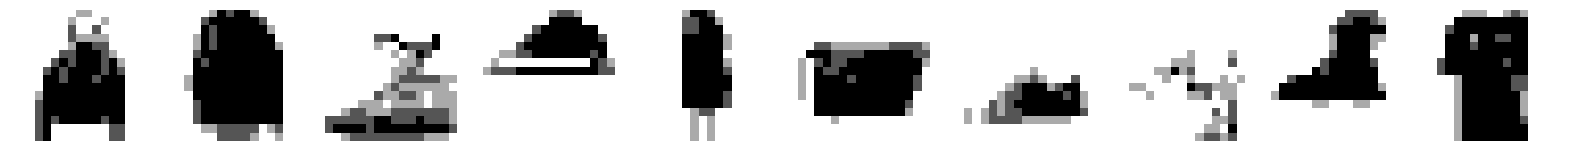

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3298
Epoch 77/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3309
Saved to /content/images/generated_img_076.png


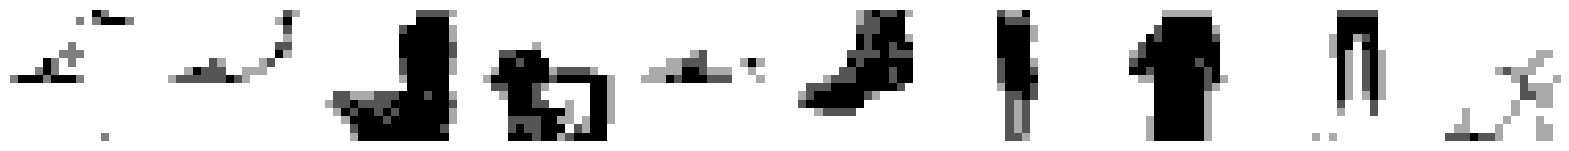

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3309
Epoch 78/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3305
Saved to /content/images/generated_img_077.png


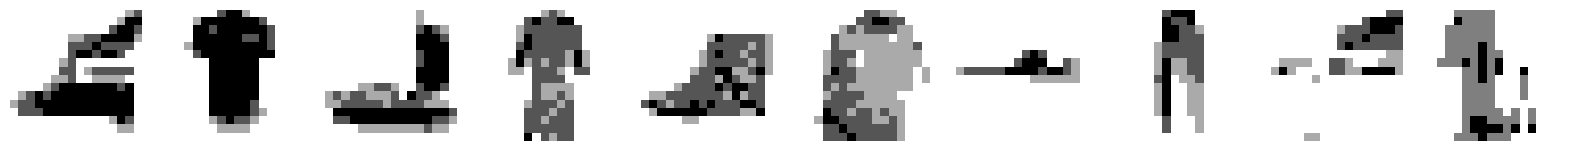

469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - loss: 0.3305
Epoch 79/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3300
Saved to /content/images/generated_img_078.png


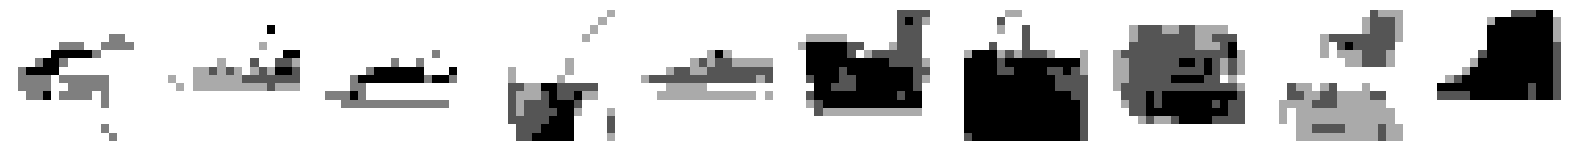

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.3300
Epoch 80/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3295
Saved to /content/images/generated_img_079.png


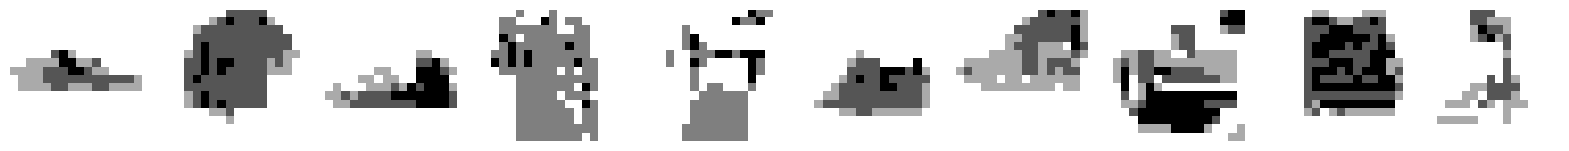

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3295
Epoch 81/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3295
Saved to /content/images/generated_img_080.png


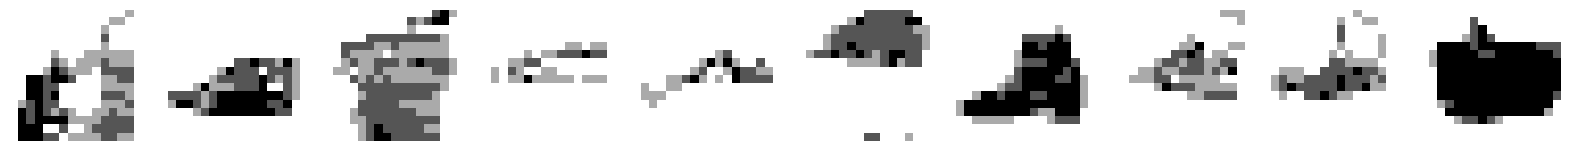

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3295
Epoch 82/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3286
Saved to /content/images/generated_img_081.png


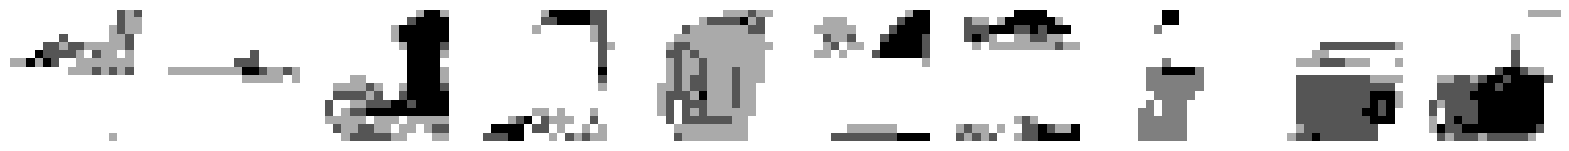

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3286
Epoch 83/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3300
Saved to /content/images/generated_img_082.png


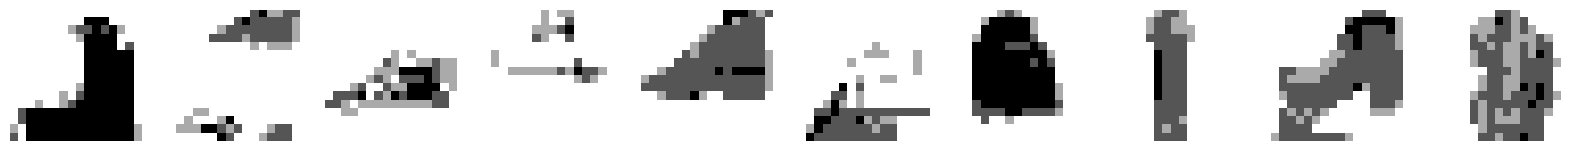

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - loss: 0.3300
Epoch 84/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3288
Saved to /content/images/generated_img_083.png


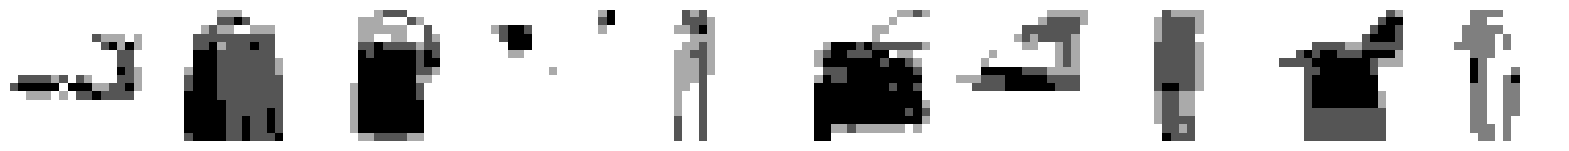

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.3288
Epoch 85/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3293
Saved to /content/images/generated_img_084.png


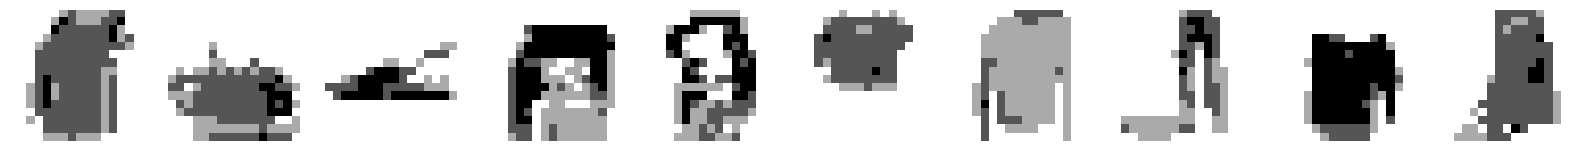

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3293
Epoch 86/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3292
Saved to /content/images/generated_img_085.png


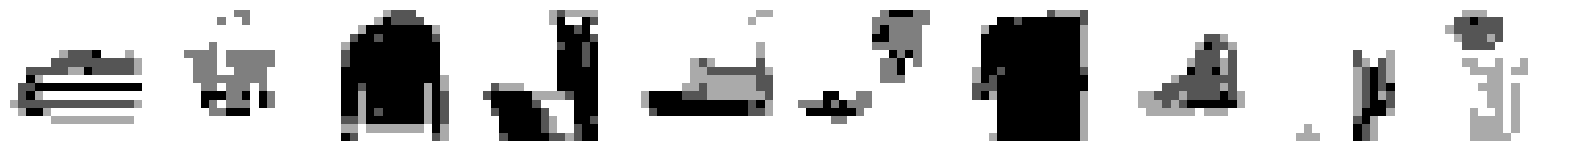

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 0.3292
Epoch 87/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3287
Saved to /content/images/generated_img_086.png


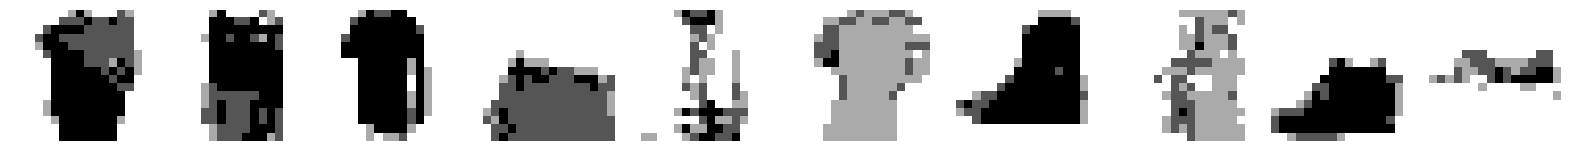

469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 52ms/step - loss: 0.3287
Epoch 88/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3281
Saved to /content/images/generated_img_087.png


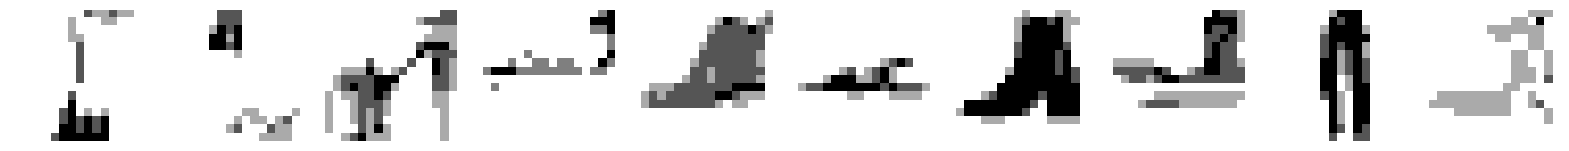

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - loss: 0.3281
Epoch 89/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3282
Saved to /content/images/generated_img_088.png


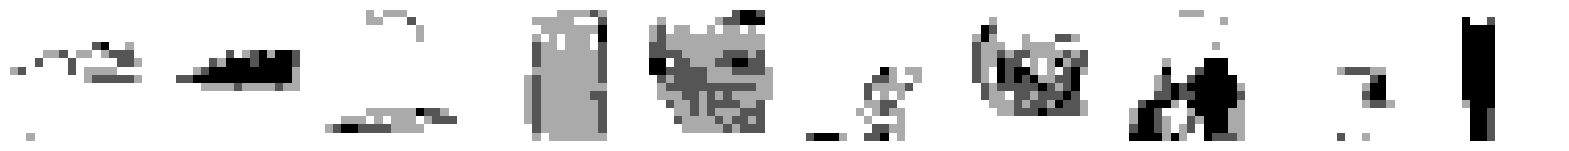

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3282
Epoch 90/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3294
Saved to /content/images/generated_img_089.png


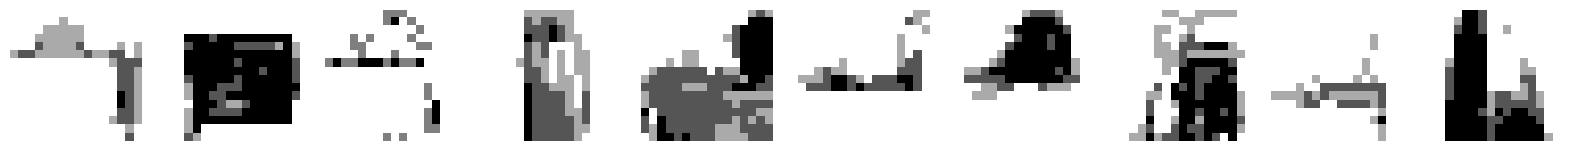

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3294
Epoch 91/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3275
Saved to /content/images/generated_img_090.png


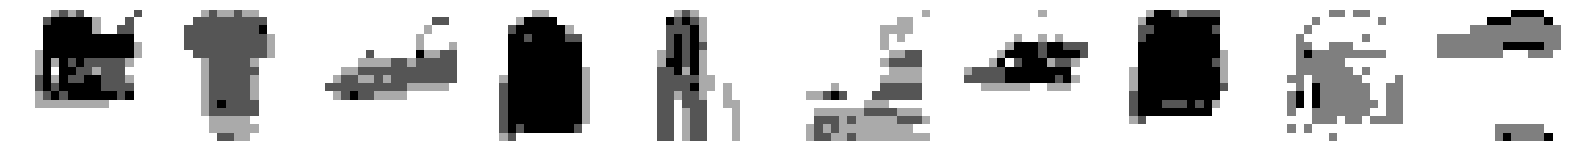

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3275
Epoch 92/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3278
Saved to /content/images/generated_img_091.png


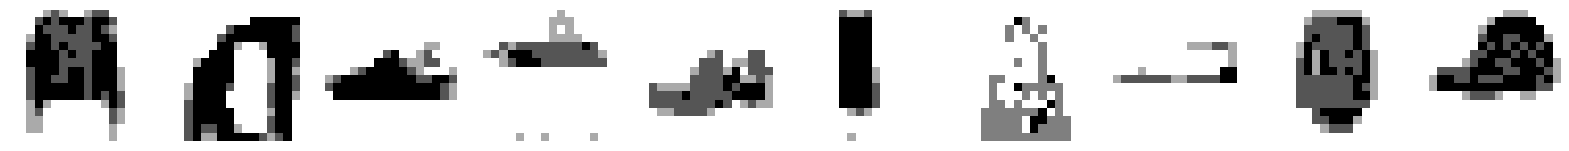

469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - loss: 0.3278
Epoch 93/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3289
Saved to /content/images/generated_img_092.png


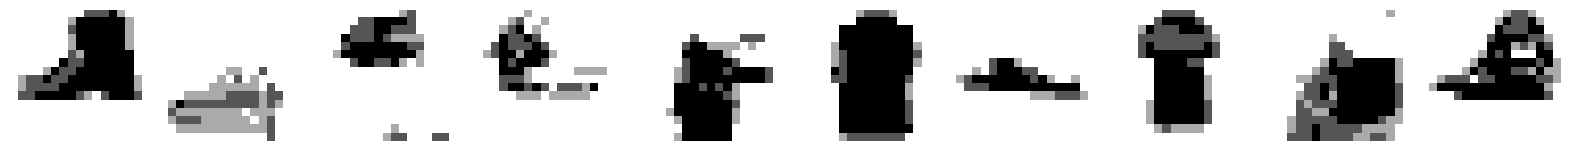

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - loss: 0.3289
Epoch 94/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3282
Saved to /content/images/generated_img_093.png


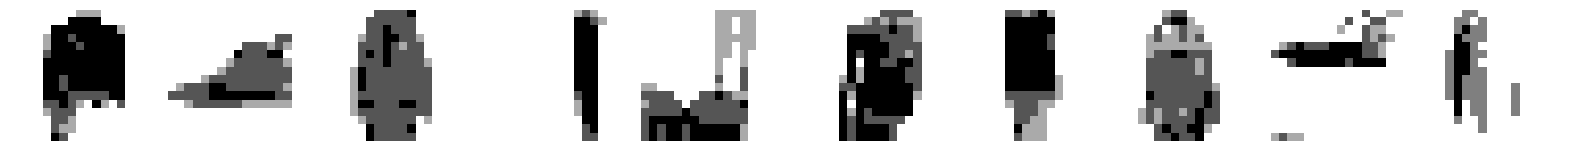

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3282
Epoch 95/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3289
Saved to /content/images/generated_img_094.png


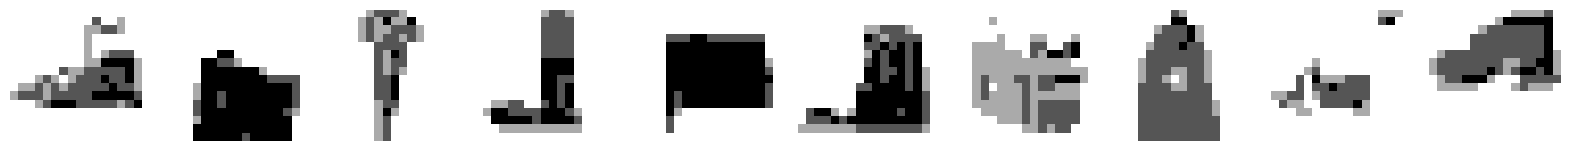

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3289
Epoch 96/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3278
Saved to /content/images/generated_img_095.png


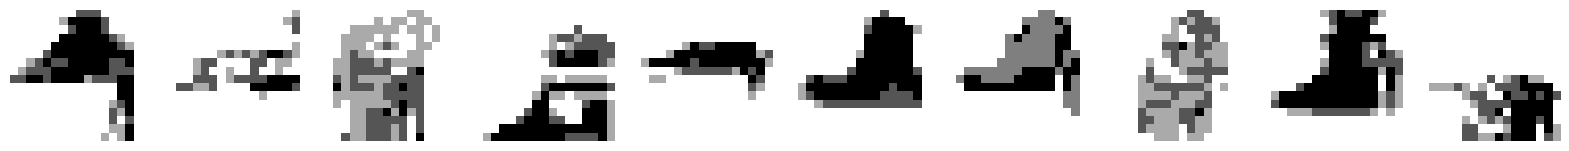

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - loss: 0.3278
Epoch 97/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3276
Saved to /content/images/generated_img_096.png


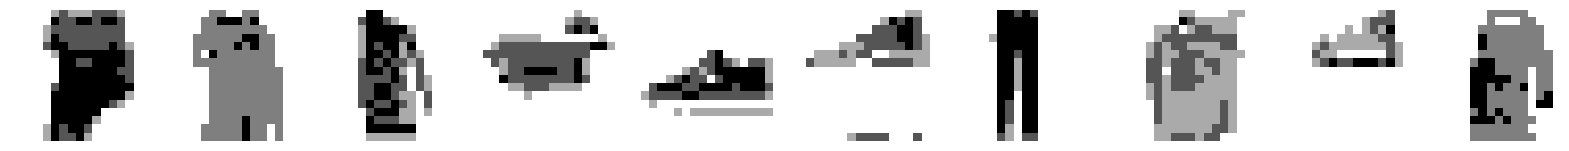

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - loss: 0.3276
Epoch 98/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3276
Saved to /content/images/generated_img_097.png


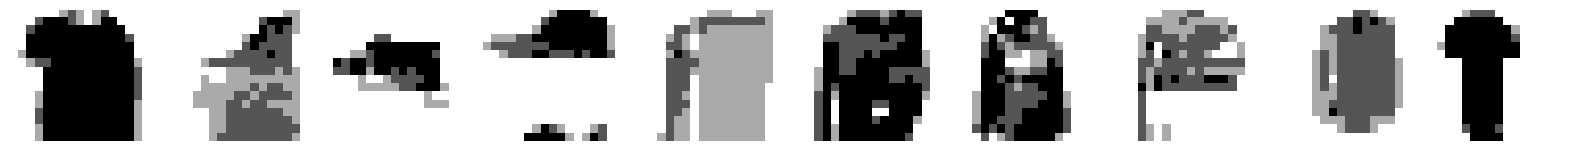

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3276
Epoch 99/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3279
Saved to /content/images/generated_img_098.png


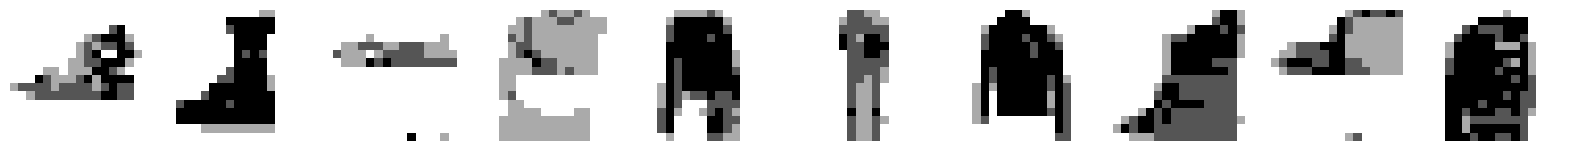

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3279
Epoch 100/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3277
Saved to /content/images/generated_img_099.png


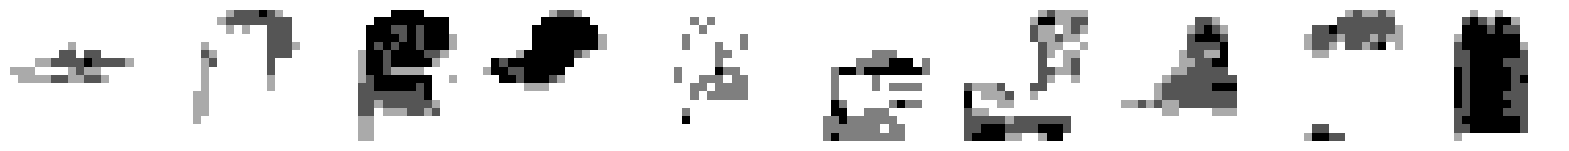

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3277
Epoch 101/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3281
Saved to /content/images/generated_img_100.png


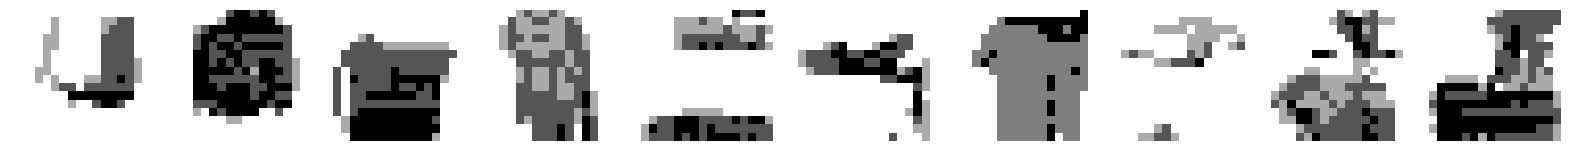

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - loss: 0.3281
Epoch 102/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3276
Saved to /content/images/generated_img_101.png


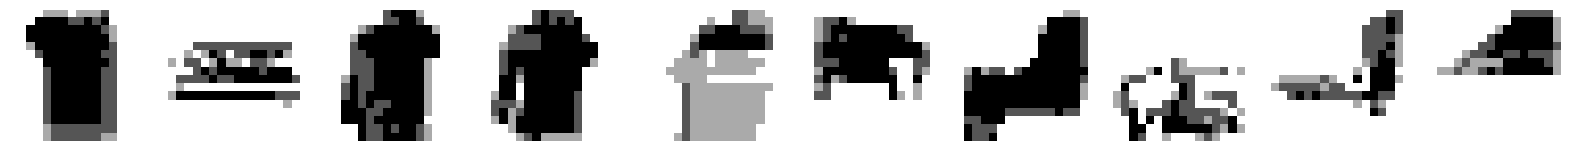

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.3276
Epoch 103/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3273
Saved to /content/images/generated_img_102.png


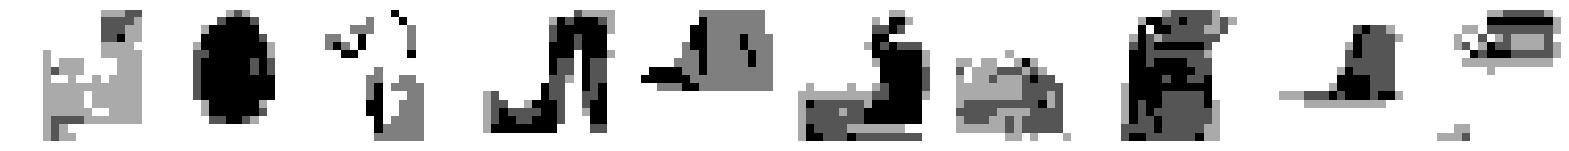

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3273
Epoch 104/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3267
Saved to /content/images/generated_img_103.png


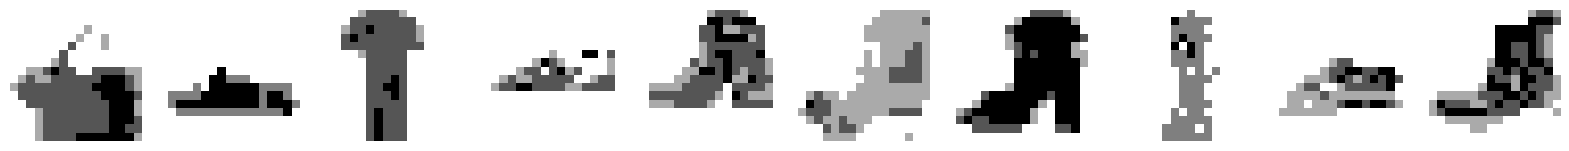

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3267
Epoch 105/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3274
Saved to /content/images/generated_img_104.png


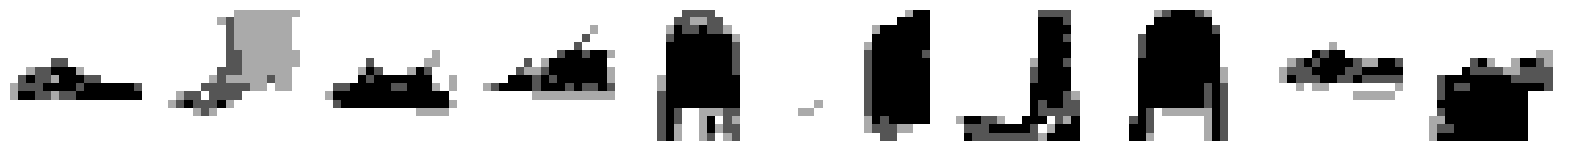

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.3274
Epoch 106/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3266
Saved to /content/images/generated_img_105.png


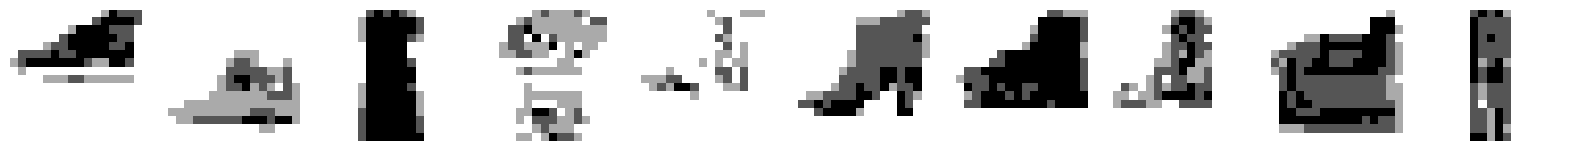

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.3266
Epoch 107/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3271
Saved to /content/images/generated_img_106.png


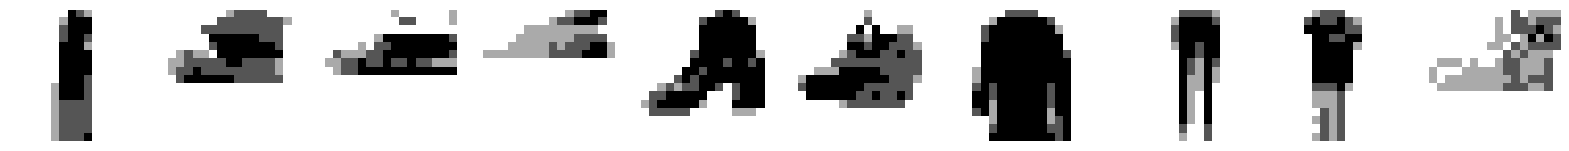

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3271
Epoch 108/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3264
Saved to /content/images/generated_img_107.png


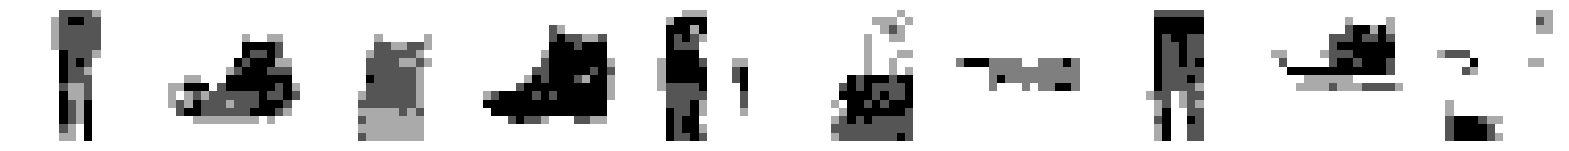

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3264
Epoch 109/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3255
Saved to /content/images/generated_img_108.png


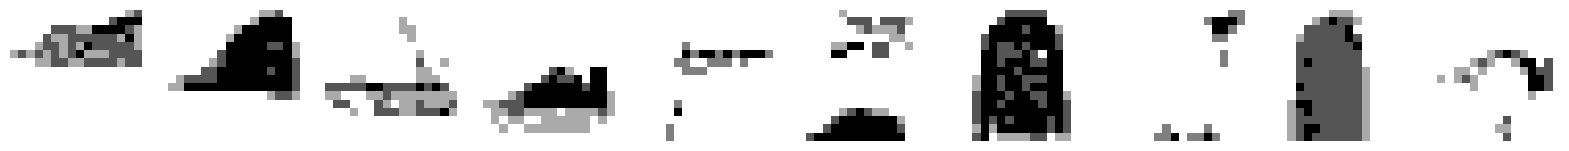

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3255
Epoch 110/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3268
Saved to /content/images/generated_img_109.png


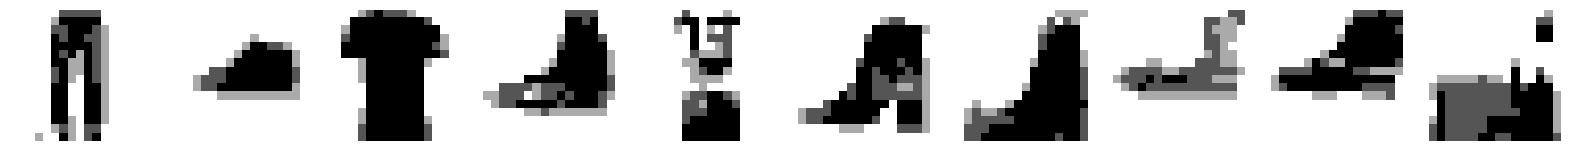

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3268
Epoch 111/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3257
Saved to /content/images/generated_img_110.png


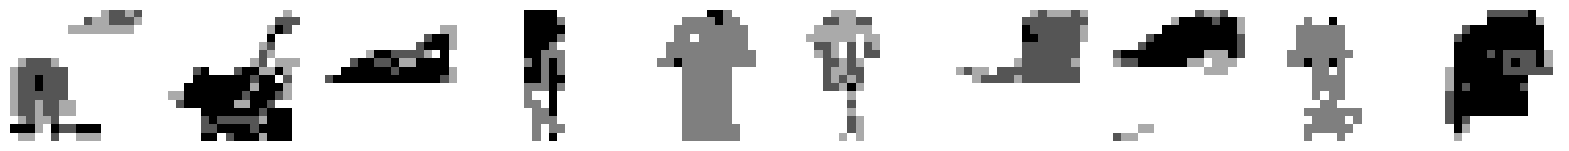

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 0.3257
Epoch 112/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3253
Saved to /content/images/generated_img_111.png


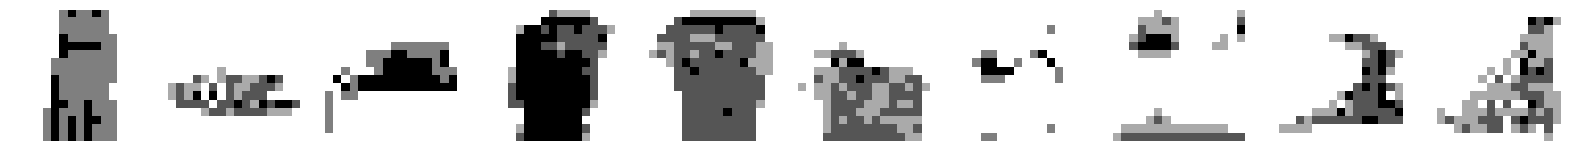

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.3253
Epoch 113/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3258
Saved to /content/images/generated_img_112.png


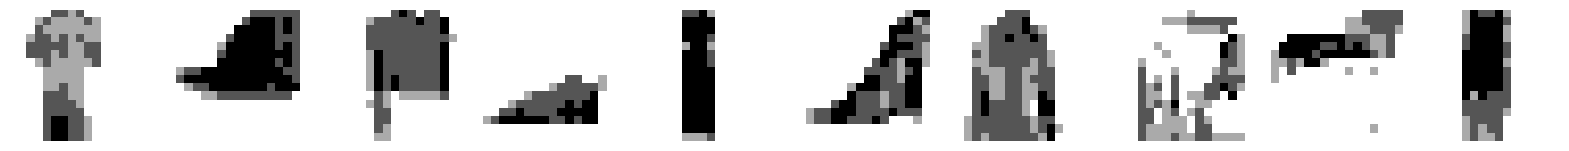

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.3258
Epoch 114/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3259
Saved to /content/images/generated_img_113.png


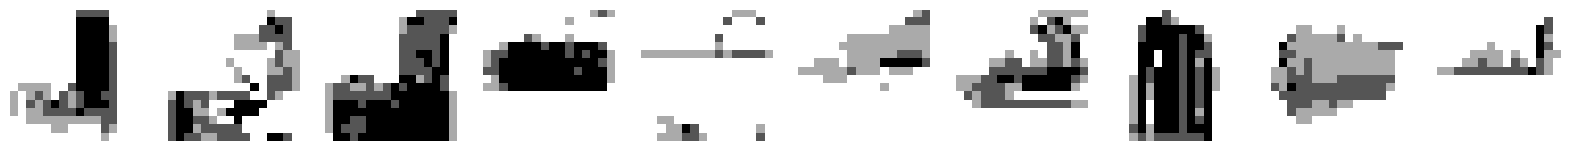

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3259
Epoch 115/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3259
Saved to /content/images/generated_img_114.png


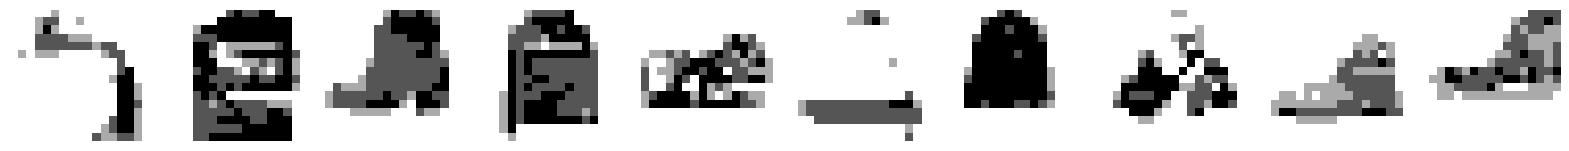

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - loss: 0.3259
Epoch 116/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3249
Saved to /content/images/generated_img_115.png


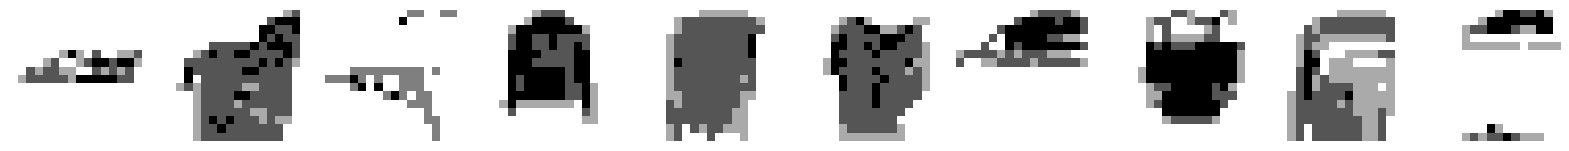

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3249
Epoch 117/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3258
Saved to /content/images/generated_img_116.png


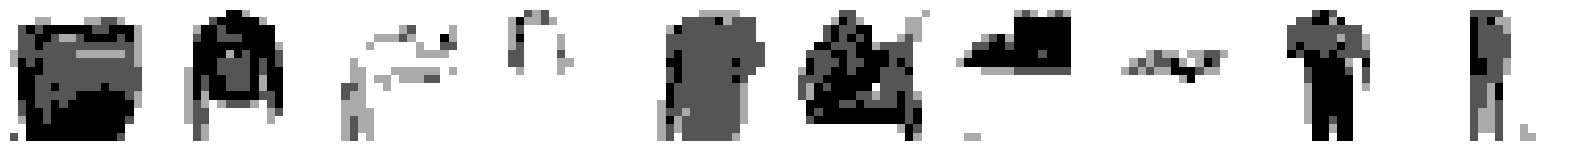

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.3258
Epoch 118/150
461/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3259
Saved to /content/images/generated_img_117.png


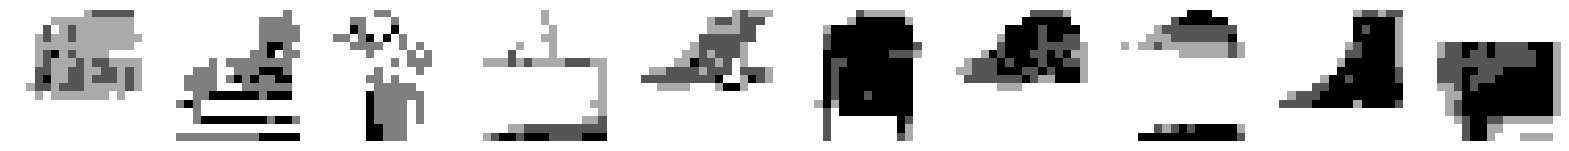

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.3259
Epoch 119/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3256
Saved to /content/images/generated_img_118.png


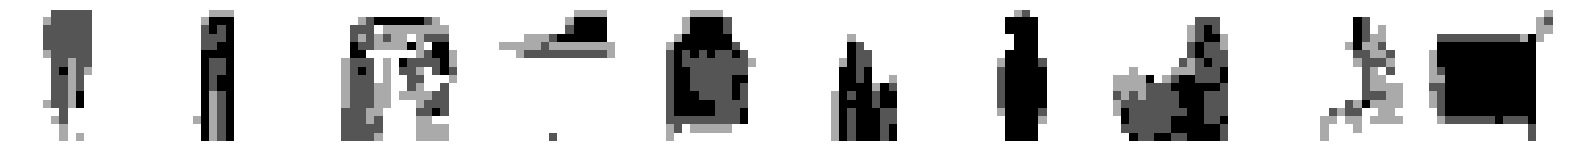

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3256
Epoch 120/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3259
Saved to /content/images/generated_img_119.png


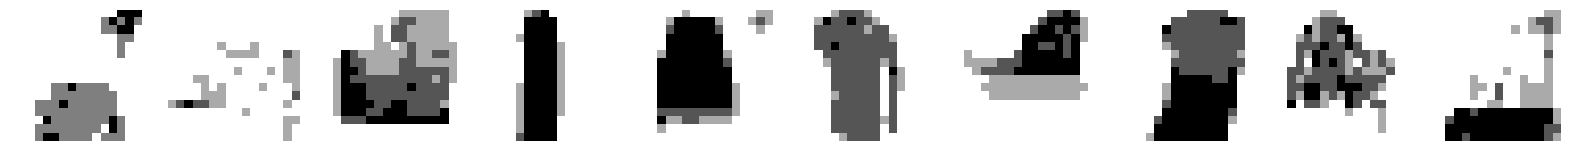

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 0.3259
Epoch 121/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3249
Saved to /content/images/generated_img_120.png


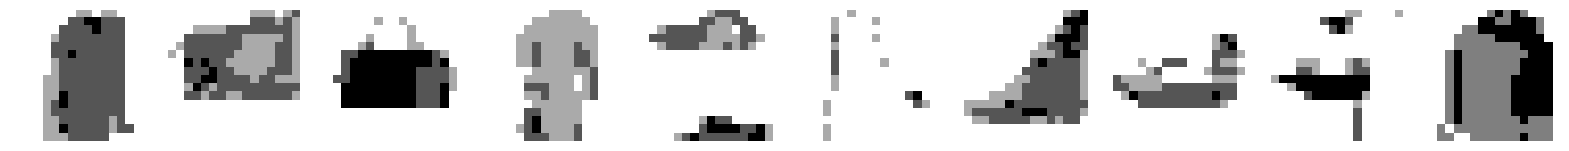

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.3249
Epoch 122/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3254
Saved to /content/images/generated_img_121.png


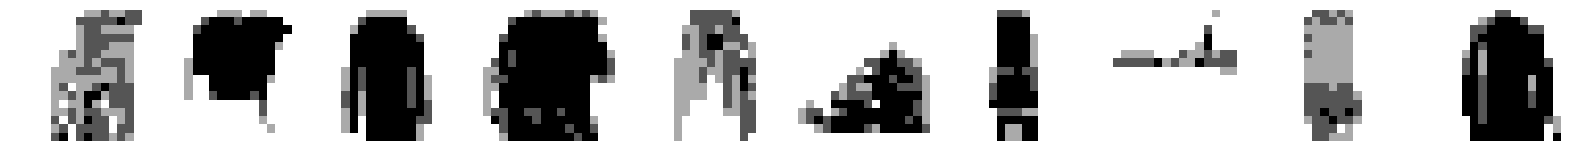

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.3254
Epoch 123/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3252
Saved to /content/images/generated_img_122.png


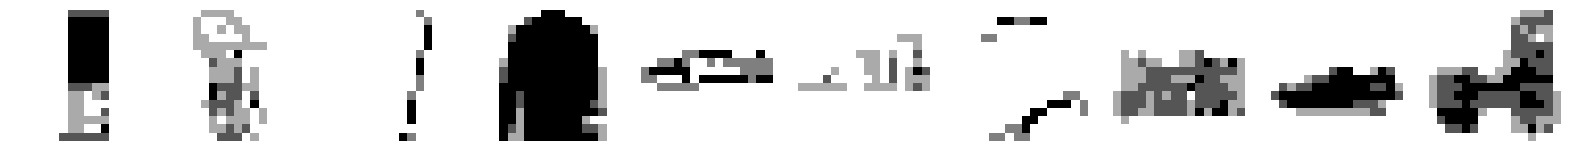

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.3252
Epoch 124/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3250
Saved to /content/images/generated_img_123.png


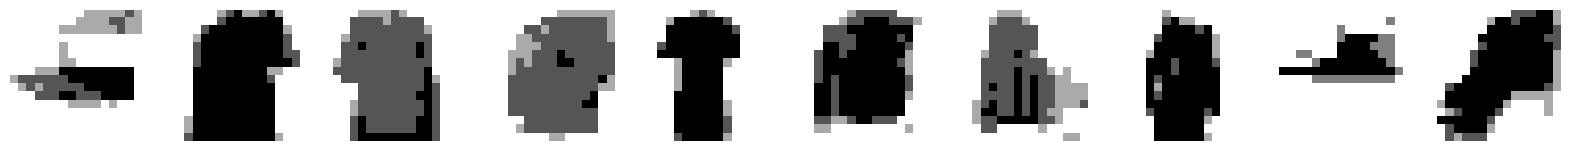

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3250
Epoch 125/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3251
Saved to /content/images/generated_img_124.png


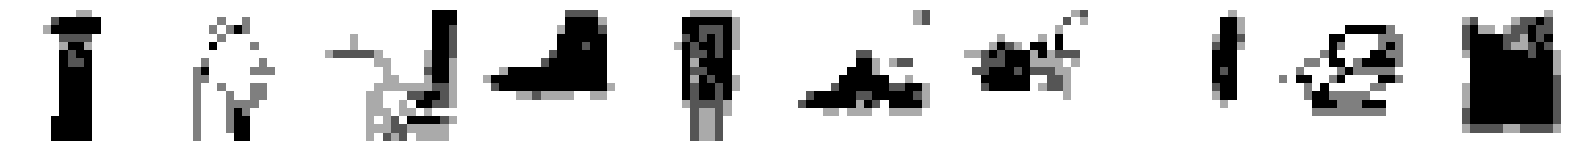

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 0.3251
Epoch 126/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3247
Saved to /content/images/generated_img_125.png


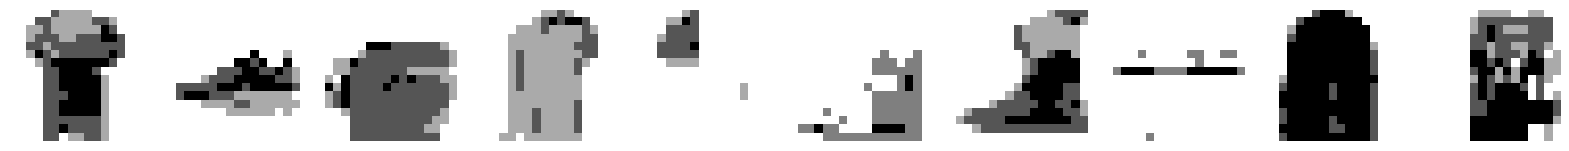

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.3247
Epoch 127/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3254
Saved to /content/images/generated_img_126.png


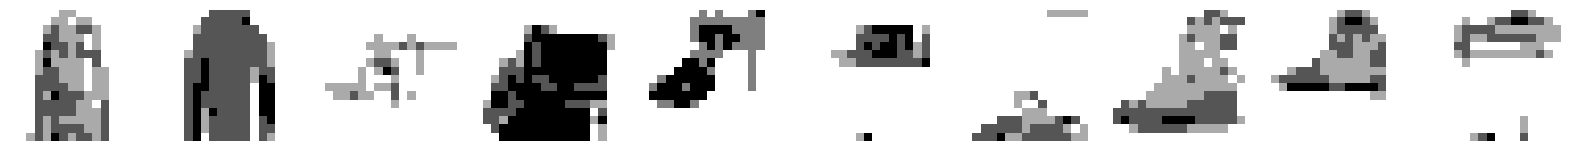

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.3254
Epoch 128/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3235
Saved to /content/images/generated_img_127.png


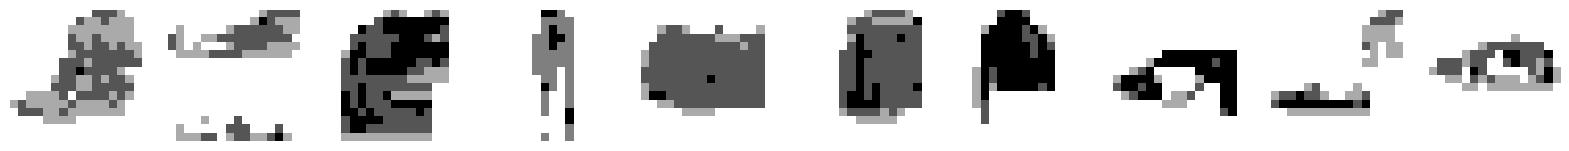

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.3235
Epoch 129/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3246
Saved to /content/images/generated_img_128.png


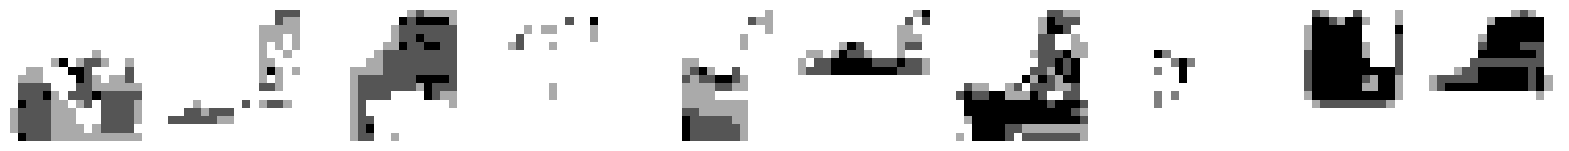

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3246
Epoch 130/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3247
Saved to /content/images/generated_img_129.png


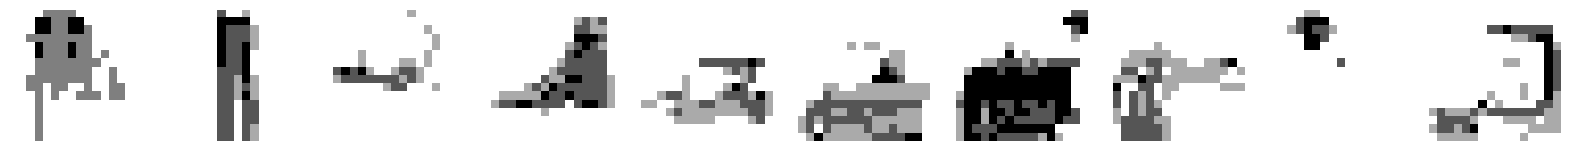

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 0.3247
Epoch 131/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3240
Saved to /content/images/generated_img_130.png


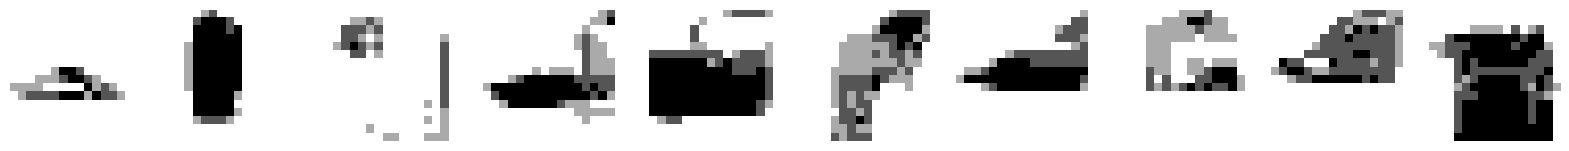

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.3240
Epoch 132/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3251
Saved to /content/images/generated_img_131.png


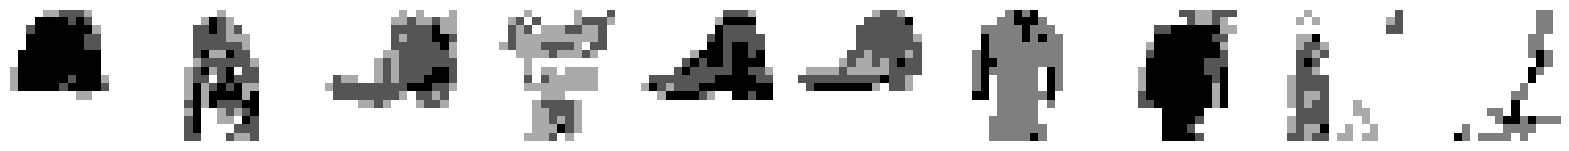

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.3251
Epoch 133/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3245
Saved to /content/images/generated_img_132.png


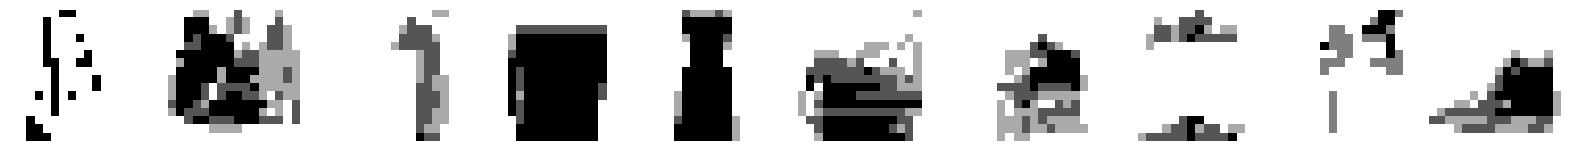

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.3245
Epoch 134/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3247
Saved to /content/images/generated_img_133.png


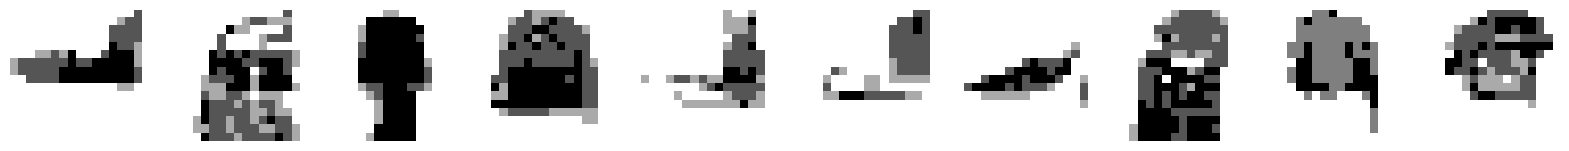

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3247
Epoch 135/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3235
Saved to /content/images/generated_img_134.png


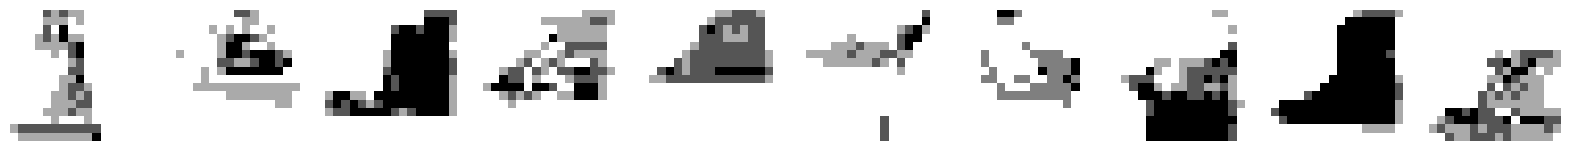

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 0.3236
Epoch 136/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3250
Saved to /content/images/generated_img_135.png


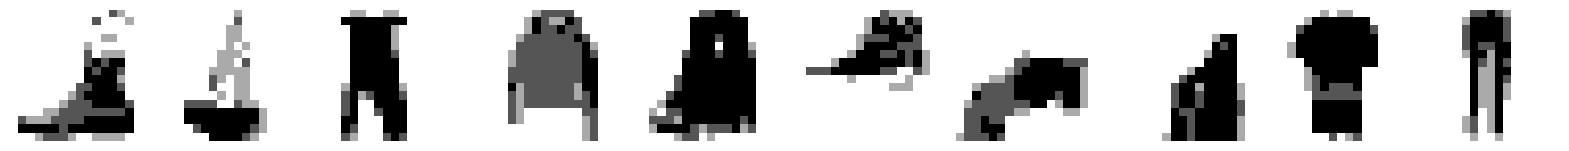

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.3250
Epoch 137/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3245
Saved to /content/images/generated_img_136.png


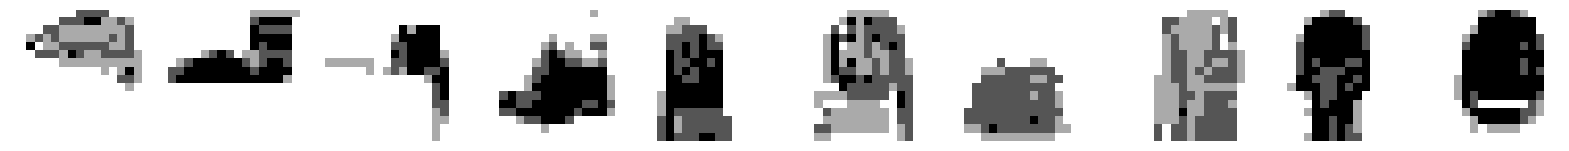

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.3245
Epoch 138/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3241
Saved to /content/images/generated_img_137.png


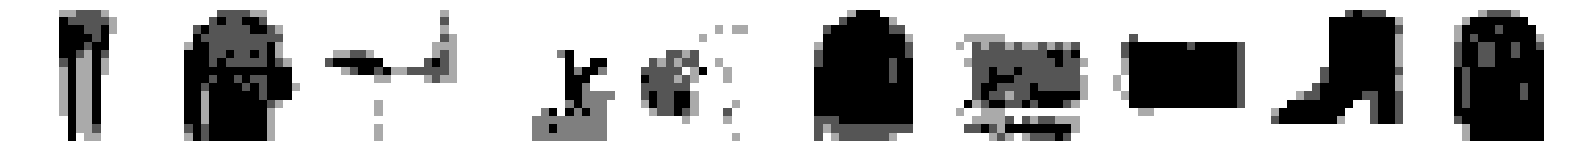

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.3241
Epoch 139/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3237
Saved to /content/images/generated_img_138.png


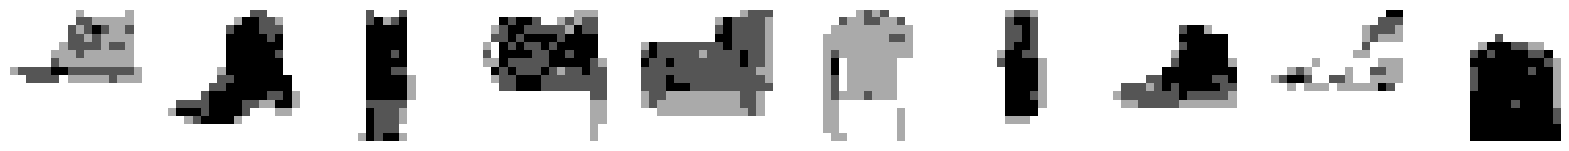

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3237
Epoch 140/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3237
Saved to /content/images/generated_img_139.png


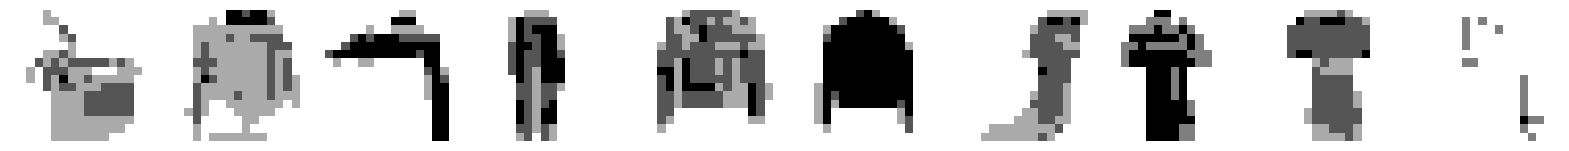

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.3237
Epoch 141/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3240
Saved to /content/images/generated_img_140.png


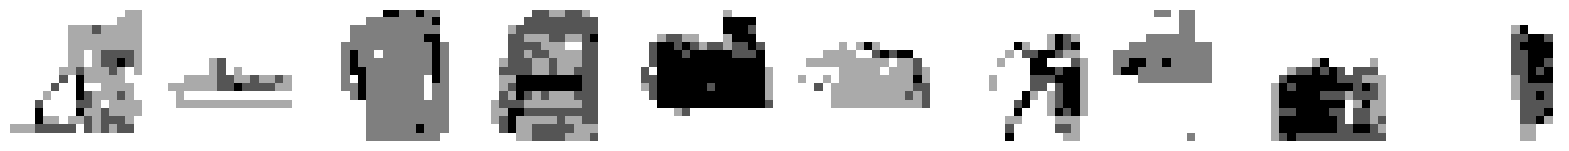

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.3240
Epoch 142/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3240
Saved to /content/images/generated_img_141.png


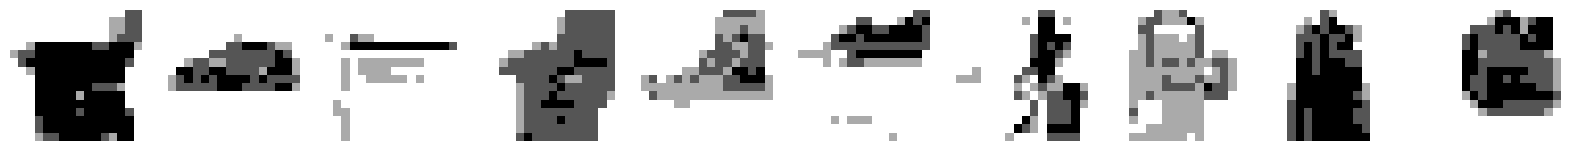

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - loss: 0.3240
Epoch 143/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3236
Saved to /content/images/generated_img_142.png


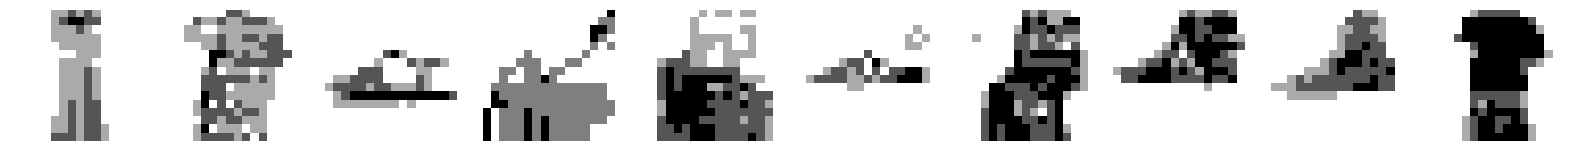

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.3236
Epoch 144/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3238
Saved to /content/images/generated_img_143.png


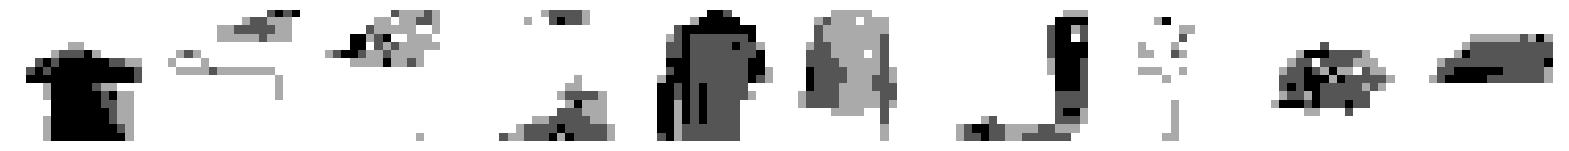

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 0.3238
Epoch 145/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3241
Saved to /content/images/generated_img_144.png


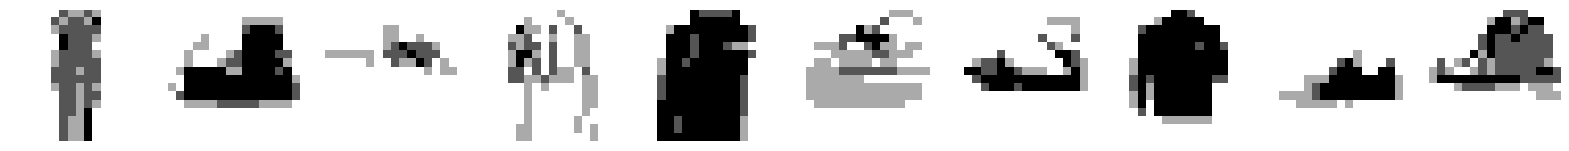

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.3241
Epoch 146/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3235
Saved to /content/images/generated_img_145.png


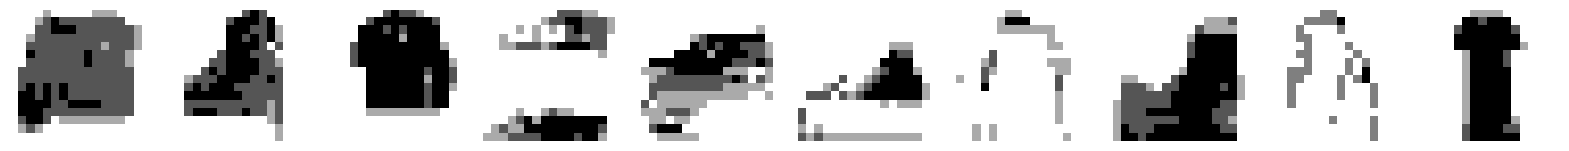

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.3235
Epoch 147/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3233
Saved to /content/images/generated_img_146.png


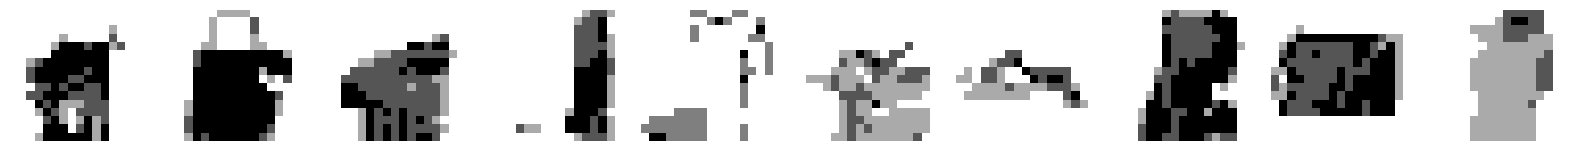

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.3233
Epoch 148/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3227
Saved to /content/images/generated_img_147.png


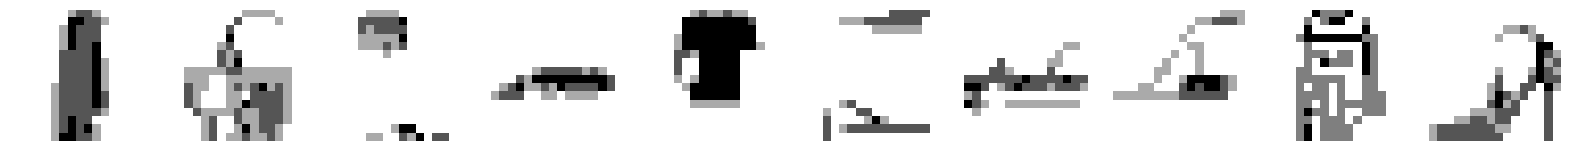

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.3227
Epoch 149/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3233
Saved to /content/images/generated_img_148.png


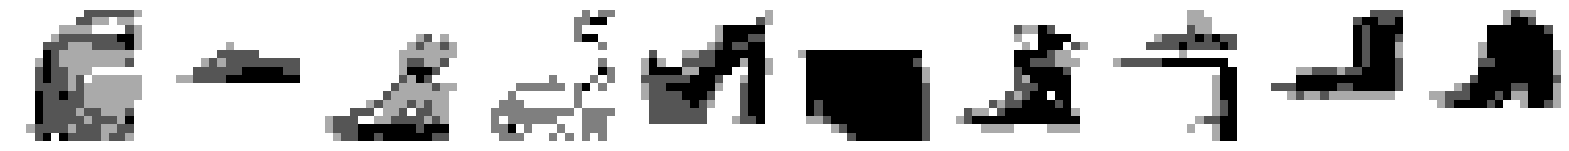

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 0.3233
Epoch 150/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3232
Saved to /content/images/generated_img_149.png


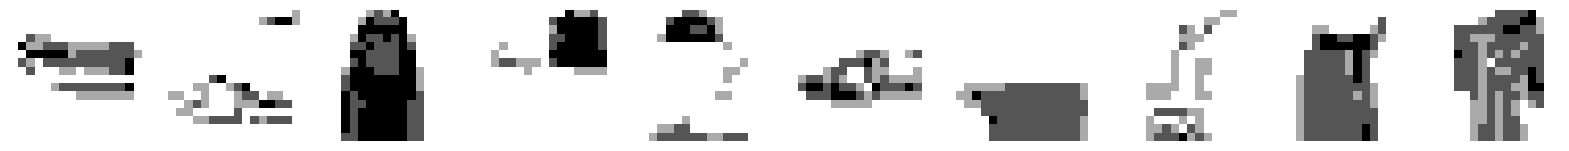

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.3232


In [26]:
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)